### Importing packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import datetime
from fbprophet import Prophet

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans 
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import linkage, dendrogram 

import sys
sys.path.append('/mnt/home/roopa.sondur_outlook/custom-packages/python3')
import stockstats
from stockstats import StockDataFrame as Sdf

from nsepy import get_history
from datetime import date

import Technical_Indicators_v3 as ti

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Portfolio Creation

### Importing pandas_datareader and fix_yahoo_finance packages to download financial data from yahoo finance

In [2]:
from pandas_datareader import data as pdr

""" Yahoo! finance has decommissioned their historical data API, causing many programs that relied on it to stop working.
fix-yahoo-finance offers a temporary fix to the problem by scraping the data from Yahoo! finance and returns a 
Pandas DataFrame/Panel in the same format as pandas_datareader's get_data_yahoo() """

import fix_yahoo_finance as yf

""" Changing the functionality/implementation of pandas_datareader's get_data_yahoo() method 
of superclass by overriding in the subclass """

yf.pdr_override() 

### ind_nifty50list.csv contains the list of stocks for NIFTY50 index

In [3]:
df = pd.read_csv ('ind_nifty50list.csv')
df

,Company Name,Industry,Symbol,Series,ISIN Code
0,Adani Ports and Special Economic Zone Ltd.,SERVICES,ADANIPORTS,EQ,INE742F01042
1,Ambuja Cements Ltd.,CEMENT & CEMENT PRODUCTS,AMBUJACEM,EQ,INE079A01024
2,Asian Paints Ltd.,CONSUMER GOODS,ASIANPAINT,EQ,INE021A01026
3,Aurobindo Pharma Ltd.,PHARMA,AUROPHARMA,EQ,INE406A01037
4,Axis Bank Ltd.,FINANCIAL SERVICES,AXISBANK,EQ,INE238A01034
5,Bajaj Auto Ltd.,AUTOMOBILE,BAJAJ-AUTO,EQ,INE917I01010
6,Bajaj Finance Ltd.,FINANCIAL SERVICES,BAJFINANCE,EQ,INE296A01024
7,Bharat Petroleum Corporation Ltd.,ENERGY,BPCL,EQ,INE029A01011
8,Bharti Airtel Ltd.,TELECOM,BHARTIARTL,EQ,INE397D01024
9,Bharti Infratel Ltd.,TELECOM,INFRATEL,EQ,INE121J01017


### For yahoo data source adding .NS for NSE stock exchange prices 

In [4]:
list_stocks = df['Symbol'].values

tickers  =  []
for ticker in list_stocks:
    tickers = tickers +  [ticker + '.NS']
tickers

['ADANIPORTS.NS',
 'AMBUJACEM.NS',
 'ASIANPAINT.NS',
 'AUROPHARMA.NS',
 'AXISBANK.NS',
 'BAJAJ-AUTO.NS',
 'BAJFINANCE.NS',
 'BPCL.NS',
 'BHARTIARTL.NS',
 'INFRATEL.NS',
 'BOSCHLTD.NS',
 'CIPLA.NS',
 'COALINDIA.NS',
 'DRREDDY.NS',
 'EICHERMOT.NS',
 'GAIL.NS',
 'HCLTECH.NS',
 'HDFCBANK.NS',
 'HEROMOTOCO.NS',
 'HINDALCO.NS',
 'HINDPETRO.NS',
 'HINDUNILVR.NS',
 'HDFC.NS',
 'ITC.NS',
 'ICICIBANK.NS',
 'IBULHSGFIN.NS',
 'IOC.NS',
 'INDUSINDBK.NS',
 'INFY.NS',
 'KOTAKBANK.NS',
 'LT.NS',
 'LUPIN.NS',
 'M&M.NS',
 'MARUTI.NS',
 'NTPC.NS',
 'ONGC.NS',
 'POWERGRID.NS',
 'RELIANCE.NS',
 'SBIN.NS',
 'SUNPHARMA.NS',
 'TCS.NS',
 'TATAMOTORS.NS',
 'TATASTEEL.NS',
 'TECHM.NS',
 'UPL.NS',
 'ULTRACEMCO.NS',
 'VEDL.NS',
 'WIPRO.NS',
 'YESBANK.NS',
 'ZEEL.NS']

In [5]:
"""Taking 2 years historic data for creating clusters on returns of stocks for a given portfolio and 
the given portfolio is of NIFTY but any collection of stocks can be given"""

start_date = '2016-01-01'
end_date = '2018-01-01'

In [6]:
panel_data =  pdr.get_data_yahoo(tickers, start_date, end_date)


[*********************100%***********************]  50 of 50 downloaded


In [7]:
panel_data

<class 'pandas.core.panel.Panel'>
Dimensions: 6 (items) x 495 (major_axis) x 50 (minor_axis)
Items axis: Open to Volume
Major_axis axis: 2016-01-01 00:00:00 to 2018-01-01 00:00:00
Minor_axis axis: ADANIPORTS.NS to ZEEL.NS

### Getting the 'Adjusted Close' prices and creating a dataframe

In [8]:
close = panel_data.loc['Adj Close']
close.head()

,ADANIPORTS.NS,AMBUJACEM.NS,ASIANPAINT.NS,AUROPHARMA.NS,AXISBANK.NS,BAJAJ-AUTO.NS,BAJFINANCE.NS,BHARTIARTL.NS,BOSCHLTD.NS,BPCL.NS,...,TATAMOTORS.NS,TATASTEEL.NS,TCS.NS,TECHM.NS,ULTRACEMCO.NS,UPL.NS,VEDL.NS,WIPRO.NS,YESBANK.NS,ZEEL.NS
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,265.468170,197.518921,865.690552,872.969727,441.395172,2409.323730,586.286011,336.128601,18989.029297,249.849167,...,401.737305,235.159988,2321.951416,501.983856,2809.291016,433.057312,79.123680,268.928864,133.749847,426.534668
2016-01-04,255.942886,194.157303,867.710144,836.224548,430.112579,2376.169189,582.111877,322.604462,18609.826172,248.566788,...,376.897339,234.703522,2276.980469,498.460632,2734.830811,426.664948,76.792702,269.532959,128.874252,415.745697
2016-01-05,253.710373,195.934158,887.265137,855.240967,428.199463,2394.349121,576.860535,319.297485,18428.828125,251.689423,...,374.298431,250.600525,2257.137451,503.769592,2718.814697,428.090912,79.771172,269.146362,129.230331,418.800049
2016-01-06,249.840729,195.021729,873.226929,858.905518,422.558167,2378.226074,587.382446,318.063538,18516.953125,254.380493,...,365.751862,245.529755,2288.511719,506.858368,2721.052979,436.007629,76.749535,268.276398,128.527313,416.928009
2016-01-07,243.093628,189.787216,859.385742,833.451294,401.513611,2314.835693,587.291077,318.211639,18106.593750,246.559189,...,343.410919,228.308502,2278.565918,493.055176,2653.805176,410.487366,70.058769,265.739105,123.962151,409.291992


### Get the dates for all 7 days in a week for the specified 2 years

In [9]:
all_weekdays = pd.date_range(start=start_date, end=end_date, freq='D')
all_weekdays

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-26',
               '2017-12-27', '2017-12-28', '2017-12-29', '2017-12-30',
               '2017-12-31', '2018-01-01'],
              dtype='datetime64[ns]', length=732, freq='D')

### For all the holidays where there is no data - filling it with the previous day prices 

In [10]:
close = close.reindex(all_weekdays)
close.head()

,ADANIPORTS.NS,AMBUJACEM.NS,ASIANPAINT.NS,AUROPHARMA.NS,AXISBANK.NS,BAJAJ-AUTO.NS,BAJFINANCE.NS,BHARTIARTL.NS,BOSCHLTD.NS,BPCL.NS,...,TATAMOTORS.NS,TATASTEEL.NS,TCS.NS,TECHM.NS,ULTRACEMCO.NS,UPL.NS,VEDL.NS,WIPRO.NS,YESBANK.NS,ZEEL.NS
2016-01-01,265.468170,197.518921,865.690552,872.969727,441.395172,2409.323730,586.286011,336.128601,18989.029297,249.849167,...,401.737305,235.159988,2321.951416,501.983856,2809.291016,433.057312,79.123680,268.928864,133.749847,426.534668
2016-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-04,255.942886,194.157303,867.710144,836.224548,430.112579,2376.169189,582.111877,322.604462,18609.826172,248.566788,...,376.897339,234.703522,2276.980469,498.460632,2734.830811,426.664948,76.792702,269.532959,128.874252,415.745697
2016-01-05,253.710373,195.934158,887.265137,855.240967,428.199463,2394.349121,576.860535,319.297485,18428.828125,251.689423,...,374.298431,250.600525,2257.137451,503.769592,2718.814697,428.090912,79.771172,269.146362,129.230331,418.800049


In [11]:
# Check for missing values
print('Number of missing values across columns:\n', close.isnull().sum())

Number of missing values across columns:
 ADANIPORTS.NS    237
AMBUJACEM.NS     237
ASIANPAINT.NS    237
AUROPHARMA.NS    237
AXISBANK.NS      237
BAJAJ-AUTO.NS    237
BAJFINANCE.NS    237
BHARTIARTL.NS    237
BOSCHLTD.NS      237
BPCL.NS          237
CIPLA.NS         237
COALINDIA.NS     237
DRREDDY.NS       237
EICHERMOT.NS     237
GAIL.NS          237
HCLTECH.NS       237
HDFC.NS          237
HDFCBANK.NS      237
HEROMOTOCO.NS    237
HINDALCO.NS      237
HINDPETRO.NS     237
HINDUNILVR.NS    237
IBULHSGFIN.NS    237
ICICIBANK.NS     237
INDUSINDBK.NS    237
INFRATEL.NS      237
INFY.NS          237
IOC.NS           237
ITC.NS           237
KOTAKBANK.NS     237
LT.NS            237
LUPIN.NS         237
M&M.NS           237
MARUTI.NS        237
NTPC.NS          237
ONGC.NS          237
POWERGRID.NS     237
RELIANCE.NS      237
SBIN.NS          237
SUNPHARMA.NS     237
TATAMOTORS.NS    237
TATASTEEL.NS     237
TCS.NS           237
TECHM.NS         237
ULTRACEMCO.NS    237
UPL.NS       

In [12]:
# Forward fill
close = close.fillna(method='ffill')

# Backward fill
close = close.fillna(method = 'bfill')

In [13]:
close.head(10)

,ADANIPORTS.NS,AMBUJACEM.NS,ASIANPAINT.NS,AUROPHARMA.NS,AXISBANK.NS,BAJAJ-AUTO.NS,BAJFINANCE.NS,BHARTIARTL.NS,BOSCHLTD.NS,BPCL.NS,...,TATAMOTORS.NS,TATASTEEL.NS,TCS.NS,TECHM.NS,ULTRACEMCO.NS,UPL.NS,VEDL.NS,WIPRO.NS,YESBANK.NS,ZEEL.NS
2016-01-01,265.468170,197.518921,865.690552,872.969727,441.395172,2409.323730,586.286011,336.128601,18989.029297,249.849167,...,401.737305,235.159988,2321.951416,501.983856,2809.291016,433.057312,79.123680,268.928864,133.749847,426.534668
2016-01-02,265.468170,197.518921,865.690552,872.969727,441.395172,2409.323730,586.286011,336.128601,18989.029297,249.849167,...,401.737305,235.159988,2321.951416,501.983856,2809.291016,433.057312,79.123680,268.928864,133.749847,426.534668
2016-01-03,265.468170,197.518921,865.690552,872.969727,441.395172,2409.323730,586.286011,336.128601,18989.029297,249.849167,...,401.737305,235.159988,2321.951416,501.983856,2809.291016,433.057312,79.123680,268.928864,133.749847,426.534668
2016-01-04,255.942886,194.157303,867.710144,836.224548,430.112579,2376.169189,582.111877,322.604462,18609.826172,248.566788,...,376.897339,234.703522,2276.980469,498.460632,2734.830811,426.664948,76.792702,269.532959,128.874252,415.745697
2016-01-05,253.710373,195.934158,887.265137,855.240967,428.199463,2394.349121,576.860535,319.297485,18428.828125,251.689423,...,374.298431,250.600525,2257.137451,503.769592,2718.814697,428.090912,79.771172,269.146362,129.230331,418.800049
2016-01-06,249.840729,195.021729,873.226929,858.905518,422.558167,2378.226074,587.382446,318.063538,18516.953125,254.380493,...,365.751862,245.529755,2288.511719,506.858368,2721.052979,436.007629,76.749535,268.276398,128.527313,416.928009
2016-01-07,243.093628,189.787216,859.385742,833.451294,401.513611,2314.835693,587.291077,318.211639,18106.593750,246.559189,...,343.410919,228.308502,2278.565918,493.055176,2653.805176,410.487366,70.058769,265.739105,123.962151,409.291992
2016-01-08,239.521637,190.507568,861.602234,836.571167,405.879547,2273.309082,607.315369,319.692383,18024.203125,251.940445,...,353.206970,231.688690,2303.886475,504.010895,2691.109619,418.404053,69.972443,268.614746,126.673859,405.646423
2016-01-09,239.521637,190.507568,861.602234,836.571167,405.879547,2273.309082,607.315369,319.692383,18024.203125,251.940445,...,353.206970,231.688690,2303.886475,504.010895,2691.109619,418.404053,69.972443,268.614746,126.673859,405.646423
2016-01-10,239.521637,190.507568,861.602234,836.571167,405.879547,2273.309082,607.315369,319.692383,18024.203125,251.940445,...,353.206970,231.688690,2303.886475,504.010895,2691.109619,418.404053,69.972443,268.614746,126.673859,405.646423


### Caluclating daily returns by ratio of ((current adj close/ previous adj close) - 1)

In [14]:
daily_return = (close / close.shift(1)) - 1
daily_return.head()

,ADANIPORTS.NS,AMBUJACEM.NS,ASIANPAINT.NS,AUROPHARMA.NS,AXISBANK.NS,BAJAJ-AUTO.NS,BAJFINANCE.NS,BHARTIARTL.NS,BOSCHLTD.NS,BPCL.NS,...,TATAMOTORS.NS,TATASTEEL.NS,TCS.NS,TECHM.NS,ULTRACEMCO.NS,UPL.NS,VEDL.NS,WIPRO.NS,YESBANK.NS,ZEEL.NS
2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-04,-0.035881,-0.017019,0.002333,-0.042092,-0.025561,-0.013761,-0.007120,-0.040235,-0.019970,-0.005133,...,-0.061831,-0.001941,-0.019368,-0.007019,-0.026505,-0.014761,-0.029460,0.002246,-0.036453,-0.025294
2016-01-05,-0.008723,0.009152,0.022536,0.022741,-0.004448,0.007651,-0.009021,-0.010251,-0.009726,0.012563,...,-0.006896,0.067732,-0.008715,0.010651,-0.005856,0.003342,0.038786,-0.001434,0.002763,0.007347


### Replace all the NaNs in the first row with zero (as there is no previous value to calculate daily return)

In [15]:
daily_return.iloc[0, :] = 0
daily_return.head()

,ADANIPORTS.NS,AMBUJACEM.NS,ASIANPAINT.NS,AUROPHARMA.NS,AXISBANK.NS,BAJAJ-AUTO.NS,BAJFINANCE.NS,BHARTIARTL.NS,BOSCHLTD.NS,BPCL.NS,...,TATAMOTORS.NS,TATASTEEL.NS,TCS.NS,TECHM.NS,ULTRACEMCO.NS,UPL.NS,VEDL.NS,WIPRO.NS,YESBANK.NS,ZEEL.NS
2016-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-04,-0.035881,-0.017019,0.002333,-0.042092,-0.025561,-0.013761,-0.007120,-0.040235,-0.019970,-0.005133,...,-0.061831,-0.001941,-0.019368,-0.007019,-0.026505,-0.014761,-0.029460,0.002246,-0.036453,-0.025294
2016-01-05,-0.008723,0.009152,0.022536,0.022741,-0.004448,0.007651,-0.009021,-0.010251,-0.009726,0.012563,...,-0.006896,0.067732,-0.008715,0.010651,-0.005856,0.003342,0.038786,-0.001434,0.002763,0.007347


### Data preparation for Unsupervised learning 

### To create a diversified portfolio of stocks we will cluster them 
### and then identify one stock from each cluster that is closest to the center of the cluster 

In [16]:
daily_return.std()

ADANIPORTS.NS    0.018530
AMBUJACEM.NS     0.012350
ASIANPAINT.NS    0.011684
AUROPHARMA.NS    0.017649
AXISBANK.NS      0.015334
BAJAJ-AUTO.NS    0.010540
BAJFINANCE.NS    0.018513
BHARTIARTL.NS    0.014689
BOSCHLTD.NS      0.012799
BPCL.NS          0.014249
CIPLA.NS         0.012449
COALINDIA.NS     0.012070
DRREDDY.NS       0.014217
EICHERMOT.NS     0.014467
GAIL.NS          0.014150
HCLTECH.NS       0.011197
HDFC.NS          0.011390
HDFCBANK.NS      0.007582
HEROMOTOCO.NS    0.011835
HINDALCO.NS      0.020336
HINDPETRO.NS     0.018284
HINDUNILVR.NS    0.010081
IBULHSGFIN.NS    0.016357
ICICIBANK.NS     0.016743
INDUSINDBK.NS    0.011290
INFRATEL.NS      0.017708
INFY.NS          0.011915
IOC.NS           0.015096
ITC.NS           0.013367
KOTAKBANK.NS     0.010192
LT.NS            0.013362
LUPIN.NS         0.015667
M&M.NS           0.011775
MARUTI.NS        0.012542
NTPC.NS          0.011735
ONGC.NS          0.013270
POWERGRID.NS     0.010931
RELIANCE.NS      0.012117
SBIN.NS     

In [17]:
daily_return.mean()

ADANIPORTS.NS    0.000731
AMBUJACEM.NS     0.000470
ASIANPAINT.NS    0.000449
AUROPHARMA.NS   -0.000181
AXISBANK.NS      0.000456
BAJAJ-AUTO.NS    0.000481
BAJFINANCE.NS    0.001646
BHARTIARTL.NS    0.000715
BOSCHLTD.NS      0.000138
BPCL.NS          0.001029
CIPLA.NS        -0.000008
COALINDIA.NS    -0.000029
DRREDDY.NS      -0.000225
EICHERMOT.NS     0.000858
GAIL.NS          0.000994
HCLTECH.NS       0.000182
HDFC.NS          0.000496
HDFCBANK.NS      0.000777
HEROMOTOCO.NS    0.000590
HINDALCO.NS      0.001808
HINDPETRO.NS     0.001596
HINDUNILVR.NS    0.000714
IBULHSGFIN.NS    0.000935
ICICIBANK.NS     0.000547
INDUSINDBK.NS    0.000787
INFRATEL.NS      0.000035
INFY.NS          0.000050
IOC.NS           0.001218
ITC.NS           0.000398
KOTAKBANK.NS     0.000489
LT.NS            0.000669
LUPIN.NS        -0.000865
M&M.NS           0.000340
MARUTI.NS        0.001103
NTPC.NS          0.000413
ONGC.NS          0.000439
POWERGRID.NS     0.000586
RELIANCE.NS      0.000918
SBIN.NS     

In [18]:
# Before transposing daily_return

x = daily_return.std().tolist() # standard deviation of daily_return of each ticker
y = daily_return.mean().tolist() # average daily_return of each ticker

In [19]:
from sklearn.cluster import KMeans

data = pd.DataFrame({'std_dev':x, 'avg':y})
#data

#Convert DataFrame to matrix
data_mat = data.as_matrix()

cluster_range = range(1, 15)
cluster_errors = []
for num in cluster_range:
    k_means = KMeans(n_clusters=num, random_state=0)
    k_means.fit(data_mat)
    cluster_errors.append(k_means.inertia_) # within sum of square errors

clusters_df = pd.DataFrame({"num_clusters":cluster_range, "cluster_errors":cluster_errors})
clusters_df

,cluster_errors,num_clusters
0,0.000504,1
1,0.000174,2
2,0.000090,3
3,0.000063,4
4,0.000044,5
5,0.000033,6
6,0.000028,7
7,0.000024,8
8,0.000019,9
9,0.000015,10


Text(0.5,1,'Cluster_errors v/s No. of clusters')

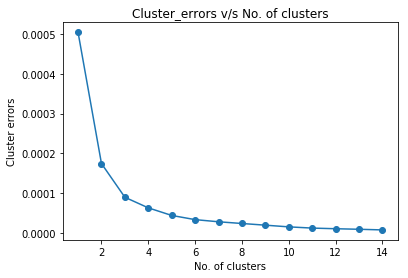

In [20]:
# Elbow plot
plt.plot(clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

# Title and axis
plt.xlabel('No. of clusters')
plt.ylabel('Cluster errors')
plt.title('Cluster_errors v/s No. of clusters')

In [21]:
# After No. of clusters=5, the cluster errors converge

num_clusters = 5  

k_means = KMeans(n_clusters = num_clusters, random_state=0)
k_means.fit(data_mat)

# Cluster label for each ticker
labels = k_means.labels_
cluster_labels = labels.tolist()
print('\ncluster_labels\n', cluster_labels)

# To find unique labels
unique_labels = list(set(cluster_labels))
print('\nunique_labels\n', unique_labels)

# Cluster centroids
cluster_centroids = np.array(k_means.cluster_centers_)
print('\ncluster_centroids\n', cluster_centroids)

# results
results = pd.DataFrame([data.index, labels]).T
results.columns = ['Ticker_index', 'Cluster_label']


# Dataframe with Ticker_name, Ticker_index, Cluster_label
tick_df = pd.DataFrame({'Ticker_name':tickers})
result_df = pd.DataFrame()
result_df = pd.concat([tick_df, results], axis=1)
#result_df

# Sort result_df by cluster label
sorted_df = result_df.sort_values('Cluster_label')
sorted_df



cluster_labels
 [4, 2, 2, 4, 0, 3, 4, 0, 2, 0, 2, 2, 0, 0, 0, 2, 2, 3, 2, 1, 4, 3, 4, 4, 2, 4, 2, 0, 0, 3, 0, 0, 2, 2, 2, 0, 2, 2, 4, 0, 4, 4, 2, 0, 2, 0, 1, 3, 0, 0]

unique_labels
 [0, 1, 2, 3, 4]

cluster_centroids
 [[0.00050746 0.01454385]
 [0.0019592  0.02195214]
 [0.00043349 0.01186983]
 [0.00054543 0.00965141]
 [0.00077911 0.01791708]]


,Ticker_name,Ticker_index,Cluster_label
49,ZEEL.NS,49,0
27,INDUSINDBK.NS,27,0
28,INFY.NS,28,0
30,LT.NS,30,0
31,LUPIN.NS,31,0
35,ONGC.NS,35,0
14,EICHERMOT.NS,14,0
13,DRREDDY.NS,13,0
48,YESBANK.NS,48,0
12,COALINDIA.NS,12,0


In [22]:
from sklearn.metrics import pairwise_distances_argmin_min

closest_ticker_ids = []
ticker_indices_within_i_cluster = []

# Converting data_mat list
data_list = data_mat.tolist()
#print('type(data_list)', type(data_list))
#print('len(data_list)', len(data_list))
#print('data_list', data_list)

for i in range(0, num_clusters):
    
    clust_centroid = cluster_centroids[i]
    #print('\nCluster centroid for cluster {}'.format(i))
    #print(clust_centroid)
    
    ticker_indices_within_i_cluster = result_df.loc[result_df['Cluster_label'] == i, 'Ticker_index'].tolist()
    #print('\nTicker indices in cluster {}'.format(i))
    #print(ticker_indices_within_i_cluster)   

    one_cluster_data_mat = np.zeros((len(ticker_indices_within_i_cluster), cluster_centroids.shape[1]))
    #print('\nInitially one_cluster_data_mat has zero values\n', one_cluster_data_mat)
    
    for row_num, data_idx in enumerate(ticker_indices_within_i_cluster):
        one_row = data_mat[data_idx]
        #print('\none_row', one_row)
        one_cluster_data_mat[row_num] = one_row
        #print('\none_cluster_data_mat[row_num]', one_cluster_data_mat)
    #print('\n')    
    #print('one_cluster_data_mat filled with co-ordinates of ticker_ids of a cluster\n', one_cluster_data_mat)

    closest, distances = pairwise_distances_argmin_min(clust_centroid.reshape(1, -1), one_cluster_data_mat)    
    closest_idx_in_one_cluster_data_mat = closest[0]
    closest_data_row_num = ticker_indices_within_i_cluster[closest_idx_in_one_cluster_data_mat]    
    #print('\nclosest_data_row_num', closest_data_row_num)
    
    data_id = data_mat[closest_data_row_num]
    data_id_list = data_id.tolist()
    #print('\ndata_id_list', data_id_list)
    #print('\ntype(data_id_list)', type(data_id_list))    
   
    ticker_id = data_list.index(data_id_list)
    #print('\nticker_id', ticker_id)
   
    closest_ticker_ids.append(ticker_id)


In [23]:
print('\n\n*************** We can create stock-portfolio of the below ticker_ids ***************')
print('\nFor cluster numbers 0,1,2,3,4 ticker_ids closest to their respective cluster_centroids are {}'.format(closest_ticker_ids))




*************** We can create stock-portfolio of the below ticker_ids ***************

For cluster numbers 0,1,2,3,4 ticker_ids closest to their respective cluster_centroids are [7, 19, 32, 47, 0]


In [24]:
# ticker_names
ticker_names = pd.DataFrame()

for ticker_id in closest_ticker_ids:
    temp = pd.DataFrame(result_df.loc[result_df['Ticker_index'] == ticker_id, 'Ticker_name'])
    #print(temp)
    ticker_names = ticker_names.append(temp)

ticker_names = ticker_names.reset_index()
ticker_names.columns = ['Ticker_index', 'Ticker_name']

ticker_names

,Ticker_index,Ticker_name
0,7,BPCL.NS
1,19,HINDALCO.NS
2,32,M&M.NS
3,47,WIPRO.NS
4,0,ADANIPORTS.NS


In [25]:
# Writing the ticker names of the portfolio into .csv file

ticker_names.to_csv('Portfolio_stocks.csv')

# Data preparation for Visualization and Model building

In [26]:
trading_tickers = pd.read_csv('Portfolio_stocks.csv')
trading_tickers

,Unnamed: 0,Ticker_index,Ticker_name
0,0,7,BPCL.NS
1,1,19,HINDALCO.NS
2,2,32,M&M.NS
3,3,47,WIPRO.NS
4,4,0,ADANIPORTS.NS


In [27]:
# To remove 'Unnamed' column from the dataframe

trading_tickers = trading_tickers.loc[:, ~trading_tickers.columns.str.contains('^Unnamed')]
trading_tickers

,Ticker_index,Ticker_name
0,7,BPCL.NS
1,19,HINDALCO.NS
2,32,M&M.NS
3,47,WIPRO.NS
4,0,ADANIPORTS.NS


In [28]:
tickers_for_model = trading_tickers.Ticker_name.tolist()
tickers_for_model

['BPCL.NS', 'HINDALCO.NS', 'M&M.NS', 'WIPRO.NS', 'ADANIPORTS.NS']

In [29]:
# Setting dates to fetch 3 years of historic data

start_date = '2015-01-01'
end_date = '2018-01-01'

In [30]:
all_weekdays = pd.date_range(start=start_date, end=end_date, freq='D')
all_weekdays

DatetimeIndex(['2015-01-01', '2015-01-02', '2015-01-03', '2015-01-04',
               '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08',
               '2015-01-09', '2015-01-10',
               ...
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-26',
               '2017-12-27', '2017-12-28', '2017-12-29', '2017-12-30',
               '2017-12-31', '2018-01-01'],
              dtype='datetime64[ns]', length=1097, freq='D')

### Fetching data for NIFTY 50 (^NSEI)

In [31]:
nse =  pdr.get_data_yahoo('^NSEI', start_date, end_date)

[*********************100%***********************]  1 of 1 downloaded


In [32]:
nse.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,8288.700195,8410.599609,8288.700195,8395.450195,8395.450195,101900
2015-01-05,8407.950195,8445.599609,8363.900391,8378.400391,8378.400391,118200
2015-01-06,8325.299805,8327.849609,8111.350098,8127.350098,8127.350098,172800
2015-01-07,8118.649902,8151.200195,8065.450195,8102.100098,8102.100098,164100
2015-01-08,8191.399902,8243.500000,8167.299805,8234.599609,8234.599609,143800


In [33]:
nse = nse.reindex(all_weekdays)
nse.head()

,Open,High,Low,Close,Adj Close,Volume
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,8288.700195,8410.599609,8288.700195,8395.450195,8395.450195,101900.0
2015-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,8407.950195,8445.599609,8363.900391,8378.400391,8378.400391,118200.0


In [34]:
nse.rename(columns={'Adj Close': 'NSE'}, inplace=True)
nse.drop (['Open','Close','High','Low','Volume'] , axis =1 , inplace = True)
nse.head()

,NSE
2015-01-01,NaN
2015-01-02,8395.450195
2015-01-03,NaN
2015-01-04,NaN
2015-01-05,8378.400391


### Fetching data for S&P 500 (^GSPC)

In [35]:
spy =  pdr.get_data_yahoo('^GSPC', start_date, end_date)

[*********************100%***********************]  1 of 1 downloaded


In [36]:
spy.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,2058.899902,2072.360107,2046.040039,2058.199951,2058.199951,2708700000
2015-01-05,2054.439941,2054.439941,2017.339966,2020.579956,2020.579956,3799120000
2015-01-06,2022.150024,2030.250000,1992.439941,2002.609985,2002.609985,4460110000
2015-01-07,2005.550049,2029.609985,2005.550049,2025.900024,2025.900024,3805480000
2015-01-08,2030.609985,2064.080078,2030.609985,2062.139893,2062.139893,3934010000


In [37]:
spy = spy.reindex(all_weekdays)
spy.head()

,Open,High,Low,Close,Adj Close,Volume
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,2058.899902,2072.360107,2046.040039,2058.199951,2058.199951,2.708700e+09
2015-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,2054.439941,2054.439941,2017.339966,2020.579956,2020.579956,3.799120e+09


In [38]:
spy.rename(columns={'Adj Close': 'SPY'}, inplace=True)
spy.drop (['Open','Close','High','Low','Volume'] , axis =1 , inplace = True)
spy.head()

,SPY
2015-01-01,NaN
2015-01-02,2058.199951
2015-01-03,NaN
2015-01-04,NaN
2015-01-05,2020.579956


### Fetching data for Dow Jones Industrial Average (^DJI)

In [39]:
dji =  pdr.get_data_yahoo('^DJI', start_date, end_date)

[*********************100%***********************]  1 of 1 downloaded


In [40]:
dji.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,17823.070313,17951.779297,17731.300781,17832.990234,17832.990234,76270000
2015-01-05,17821.300781,17821.300781,17475.929688,17501.650391,17501.650391,116160000
2015-01-06,17504.179688,17581.050781,17262.369141,17371.640625,17371.640625,101870000
2015-01-07,17374.779297,17597.080078,17374.779297,17584.519531,17584.519531,91030000
2015-01-08,17591.970703,17916.039063,17591.970703,17907.869141,17907.869141,114890000


In [41]:
dji = dji.reindex(all_weekdays)
dji.head()

,Open,High,Low,Close,Adj Close,Volume
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,17823.070313,17951.779297,17731.300781,17832.990234,17832.990234,76270000.0
2015-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,17821.300781,17821.300781,17475.929688,17501.650391,17501.650391,116160000.0


In [42]:
dji.rename(columns={'Adj Close': 'DJ'}, inplace=True)
dji.drop (['Open','Close','High','Low','Volume'] , axis =1 , inplace = True)
dji.head()

,DJ
2015-01-01,NaN
2015-01-02,17832.990234
2015-01-03,NaN
2015-01-04,NaN
2015-01-05,17501.650391


### Fetching data for NASDAQ Composite (^IXIC)

In [43]:
nasdaq =  pdr.get_data_yahoo('^IXIC', start_date, end_date)

[*********************100%***********************]  1 of 1 downloaded


In [44]:
nasdaq.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,4760.240234,4777.009766,4698.109863,4726.810059,4726.810059,1435150000
2015-01-05,4700.339844,4702.770020,4641.459961,4652.569824,4652.569824,1794470000
2015-01-06,4666.850098,4667.330078,4567.589844,4592.740234,4592.740234,2167320000
2015-01-07,4626.839844,4652.720215,4613.899902,4650.470215,4650.470215,1957950000
2015-01-08,4689.540039,4741.379883,4688.020020,4736.189941,4736.189941,2105450000


In [45]:
nasdaq = nasdaq.reindex(all_weekdays)
nasdaq.head()

,Open,High,Low,Close,Adj Close,Volume
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,4760.240234,4777.009766,4698.109863,4726.810059,4726.810059,1.435150e+09
2015-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,4700.339844,4702.770020,4641.459961,4652.569824,4652.569824,1.794470e+09


In [46]:
nasdaq.rename(columns={'Adj Close': 'NASDAQ'}, inplace=True)
nasdaq.drop (['Open','Close','High','Low','Volume'] , axis =1 , inplace = True)
nasdaq.head()

,NASDAQ
2015-01-01,NaN
2015-01-02,4726.810059
2015-01-03,NaN
2015-01-04,NaN
2015-01-05,4652.569824


### Fetching data for individual stocks from the portfolio of stocks

### Fetching data for Stock-1

In [47]:
print('Fetching historic stock data for {}'.format(tickers_for_model[0]))

Fetching historic stock data for BPCL.NS


In [48]:
stock1_df =  pdr.get_data_yahoo(tickers_for_model[0], start_date, end_date)
stock1_df.head()

[*********************100%***********************]  1 of 1 downloaded


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-01,216.300003,219.167007,214.067001,218.067001,168.424866,1446501
2015-01-02,216.966995,218.632996,214.149994,214.800003,165.901581,3071145
2015-01-05,215.000000,216.483002,213.766998,215.216995,166.223648,3283116
2015-01-06,217.466995,218.432999,210.000000,213.050003,164.549973,6560505
2015-01-07,212.332993,216.449997,212.332993,214.983002,166.042938,3928182


In [49]:
stock1_df = stock1_df.reindex(all_weekdays)
stock1_df.head()

,Open,High,Low,Close,Adj Close,Volume
2015-01-01,216.300003,219.167007,214.067001,218.067001,168.424866,1446501.0
2015-01-02,216.966995,218.632996,214.149994,214.800003,165.901581,3071145.0
2015-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,215.000000,216.483002,213.766998,215.216995,166.223648,3283116.0


In [50]:
# Fetching 'VWAP' from nsepy package for the same stock

stock1 = tickers_for_model[0].split('.')[0]
stock1

'BPCL'

In [51]:
data = get_history(symbol=stock1, start=date(2015,1,1),  end=date(2018,1,1))
data['VWAP'].head()

Date
2015-01-01    650.33
2015-01-02    648.43
2015-01-05    645.09
2015-01-06    644.43
2015-01-07    644.83
Name: VWAP, dtype: float64

In [52]:
# Joining individual stock data with 'VWAP' fetched from nsepy package

stock1_df = stock1_df.join(data['VWAP'])
stock1_df.head()

,Open,High,Low,Close,Adj Close,Volume,VWAP
2015-01-01,216.300003,219.167007,214.067001,218.067001,168.424866,1446501.0,650.33
2015-01-02,216.966995,218.632996,214.149994,214.800003,165.901581,3071145.0,648.43
2015-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,215.000000,216.483002,213.766998,215.216995,166.223648,3283116.0,645.09


### Joining individual stock data with nse, spy, dji, nasdaq data

In [53]:
stock1_df = stock1_df.join([nse, spy, dji, nasdaq])

# Forward fill
stock1_df = stock1_df.fillna(method='ffill')

# Backward fill
stock1_df = stock1_df.fillna(method = 'bfill')

stock1_df.head()

,Open,High,Low,Close,Adj Close,Volume,VWAP,NSE,SPY,DJ,NASDAQ
2015-01-01,216.300003,219.167007,214.067001,218.067001,168.424866,1446501.0,650.33,8395.450195,2058.199951,17832.990234,4726.810059
2015-01-02,216.966995,218.632996,214.149994,214.800003,165.901581,3071145.0,648.43,8395.450195,2058.199951,17832.990234,4726.810059
2015-01-03,216.966995,218.632996,214.149994,214.800003,165.901581,3071145.0,648.43,8395.450195,2058.199951,17832.990234,4726.810059
2015-01-04,216.966995,218.632996,214.149994,214.800003,165.901581,3071145.0,648.43,8395.450195,2058.199951,17832.990234,4726.810059
2015-01-05,215.000000,216.483002,213.766998,215.216995,166.223648,3283116.0,645.09,8378.400391,2020.579956,17501.650391,4652.569824


### Fetching data for Stock-2

In [54]:
print('Fetching historic stock data for {}'.format(tickers_for_model[1]))

Fetching historic stock data for HINDALCO.NS


In [55]:
stock2_df =  pdr.get_data_yahoo(tickers_for_model[1], start_date, end_date)
stock2_df.head()

[*********************100%***********************]  1 of 1 downloaded


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-01,157.399994,159.000000,155.399994,158.449997,154.607239,2350082
2015-01-02,158.899994,161.199997,158.350006,160.100006,156.217224,2923839
2015-01-05,161.000000,161.949997,155.500000,156.850006,153.046036,4830121
2015-01-06,156.300003,156.300003,151.149994,153.399994,149.679703,7054029
2015-01-07,153.800003,154.500000,146.699997,148.899994,145.288834,6638158


In [56]:
stock2_df = stock2_df.reindex(all_weekdays)
stock2_df.head()

,Open,High,Low,Close,Adj Close,Volume
2015-01-01,157.399994,159.000000,155.399994,158.449997,154.607239,2350082.0
2015-01-02,158.899994,161.199997,158.350006,160.100006,156.217224,2923839.0
2015-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,161.000000,161.949997,155.500000,156.850006,153.046036,4830121.0


In [57]:
# Fetching 'VWAP' from nsepy package

stock2 = tickers_for_model[1].split('.')[0]
stock2

'HINDALCO'

In [58]:
data = get_history(symbol=stock2, start=date(2015,1,1),  end=date(2018,1,1))
data['VWAP'].head()

Date
2015-01-01    157.80
2015-01-02    160.21
2015-01-05    158.67
2015-01-06    153.79
2015-01-07    150.60
Name: VWAP, dtype: float64

In [59]:
# Joining individual stock data with 'VWAP' fetched from nsepy package

stock2_df = stock2_df.join(data['VWAP'])
stock2_df.head()

,Open,High,Low,Close,Adj Close,Volume,VWAP
2015-01-01,157.399994,159.000000,155.399994,158.449997,154.607239,2350082.0,157.80
2015-01-02,158.899994,161.199997,158.350006,160.100006,156.217224,2923839.0,160.21
2015-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,161.000000,161.949997,155.500000,156.850006,153.046036,4830121.0,158.67


### Joining individual stock data with nse, spy, dji, nasdaq data

In [60]:
stock2_df = stock2_df.join([nse, spy, dji, nasdaq])

# Forward fill
stock2_df = stock2_df.fillna(method='ffill')

# Backward fill
stock2_df = stock2_df.fillna(method = 'bfill')

stock2_df.head()

,Open,High,Low,Close,Adj Close,Volume,VWAP,NSE,SPY,DJ,NASDAQ
2015-01-01,157.399994,159.000000,155.399994,158.449997,154.607239,2350082.0,157.80,8395.450195,2058.199951,17832.990234,4726.810059
2015-01-02,158.899994,161.199997,158.350006,160.100006,156.217224,2923839.0,160.21,8395.450195,2058.199951,17832.990234,4726.810059
2015-01-03,158.899994,161.199997,158.350006,160.100006,156.217224,2923839.0,160.21,8395.450195,2058.199951,17832.990234,4726.810059
2015-01-04,158.899994,161.199997,158.350006,160.100006,156.217224,2923839.0,160.21,8395.450195,2058.199951,17832.990234,4726.810059
2015-01-05,161.000000,161.949997,155.500000,156.850006,153.046036,4830121.0,158.67,8378.400391,2020.579956,17501.650391,4652.569824


### Fetching data for Stock-3

In [61]:
print('Fetching historic stock data for {}'.format(tickers_for_model[2]))

Fetching historic stock data for M&M.NS


In [62]:
stock3_df =  pdr.get_data_yahoo(tickers_for_model[2], start_date, end_date)
stock3_df.head()

[*********************100%***********************]  1 of 1 downloaded


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-01,619.000000,621.900024,615.049988,618.525024,585.755859,713338
2015-01-02,615.125000,621.849976,611.250000,612.325012,579.884277,1279856
2015-01-05,610.049988,624.000000,608.500000,609.224976,576.948486,1456708
2015-01-06,607.500000,612.174988,600.500000,605.825012,573.728638,2579114
2015-01-07,606.000000,615.700012,601.250000,612.075012,579.647461,2189814


In [63]:
stock3_df = stock3_df.reindex(all_weekdays)
stock3_df.head()

,Open,High,Low,Close,Adj Close,Volume
2015-01-01,619.000000,621.900024,615.049988,618.525024,585.755859,713338.0
2015-01-02,615.125000,621.849976,611.250000,612.325012,579.884277,1279856.0
2015-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,610.049988,624.000000,608.500000,609.224976,576.948486,1456708.0


In [64]:
# Fetching 'VWAP' from nsepy package

stock3 = tickers_for_model[2].split('.')[0]
stock3

'M&M'

In [65]:
data = get_history(symbol=stock3, start=date(2015,1,1),  end=date(2018,1,1))
data['VWAP'].head()

Date
2015-01-01    1236.29
2015-01-02    1232.51
2015-01-05    1229.19
2015-01-06    1212.61
2015-01-07    1222.17
Name: VWAP, dtype: float64

In [66]:
# Joining individual stock data with 'VWAP' fetched from nsepy package

stock3_df = stock3_df.join(data['VWAP'])
stock3_df.head()

,Open,High,Low,Close,Adj Close,Volume,VWAP
2015-01-01,619.000000,621.900024,615.049988,618.525024,585.755859,713338.0,1236.29
2015-01-02,615.125000,621.849976,611.250000,612.325012,579.884277,1279856.0,1232.51
2015-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,610.049988,624.000000,608.500000,609.224976,576.948486,1456708.0,1229.19


### Joining individual stock data with nse, spy, dji, nasdaq data

In [67]:
stock3_df = stock3_df.join([nse, spy, dji, nasdaq])

# Forward fill
stock3_df = stock3_df.fillna(method='ffill')

# Backward fill
stock3_df = stock3_df.fillna(method = 'bfill')

stock3_df.head()

,Open,High,Low,Close,Adj Close,Volume,VWAP,NSE,SPY,DJ,NASDAQ
2015-01-01,619.000000,621.900024,615.049988,618.525024,585.755859,713338.0,1236.29,8395.450195,2058.199951,17832.990234,4726.810059
2015-01-02,615.125000,621.849976,611.250000,612.325012,579.884277,1279856.0,1232.51,8395.450195,2058.199951,17832.990234,4726.810059
2015-01-03,615.125000,621.849976,611.250000,612.325012,579.884277,1279856.0,1232.51,8395.450195,2058.199951,17832.990234,4726.810059
2015-01-04,615.125000,621.849976,611.250000,612.325012,579.884277,1279856.0,1232.51,8395.450195,2058.199951,17832.990234,4726.810059
2015-01-05,610.049988,624.000000,608.500000,609.224976,576.948486,1456708.0,1229.19,8378.400391,2020.579956,17501.650391,4652.569824


### Fetching data for Stock-4

In [68]:
print('Fetching historic stock data for {}'.format(tickers_for_model[3]))

Fetching historic stock data for WIPRO.NS


In [69]:
stock4_df =  pdr.get_data_yahoo(tickers_for_model[3], start_date, end_date)
stock4_df.head()

[*********************100%***********************]  1 of 1 downloaded


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-01,276.274994,277.200012,275.250000,276.200012,255.972107,405956
2015-01-02,276.700012,280.125000,276.500000,278.649994,258.242645,1574608
2015-01-05,278.524994,282.500000,277.750000,279.149994,258.705994,1439476
2015-01-06,277.500000,278.200012,271.049988,272.625000,252.658890,4648762
2015-01-07,271.600006,272.500000,269.174988,270.549988,250.735809,3114594


In [70]:
stock4_df = stock4_df.reindex(all_weekdays)
stock4_df.head()

,Open,High,Low,Close,Adj Close,Volume
2015-01-01,276.274994,277.200012,275.25,276.200012,255.972107,405956.0
2015-01-02,276.700012,280.125000,276.50,278.649994,258.242645,1574608.0
2015-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,278.524994,282.500000,277.75,279.149994,258.705994,1439476.0


In [71]:
# Fetching 'VWAP' from nsepy package

stock4 = tickers_for_model[3].split('.')[0]
stock4

'WIPRO'

In [72]:
data = get_history(symbol=stock4, start=date(2015,1,1),  end=date(2018,1,1))
data['VWAP'].head()

Date
2015-01-01    552.70
2015-01-02    557.56
2015-01-05    559.97
2015-01-06    547.07
2015-01-07    541.38
Name: VWAP, dtype: float64

In [73]:
# Joining individual stock data with 'VWAP' fetched from nsepy package

stock4_df = stock4_df.join(data['VWAP'])
stock4_df.head()

,Open,High,Low,Close,Adj Close,Volume,VWAP
2015-01-01,276.274994,277.200012,275.25,276.200012,255.972107,405956.0,552.70
2015-01-02,276.700012,280.125000,276.50,278.649994,258.242645,1574608.0,557.56
2015-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,278.524994,282.500000,277.75,279.149994,258.705994,1439476.0,559.97


### Joining individual stock data with nse, spy, dji, nasdaq data

In [74]:
stock4_df = stock4_df.join([nse, spy, dji, nasdaq])

# Forward fill
stock4_df = stock4_df.fillna(method='ffill')

# Backward fill
stock4_df = stock4_df.fillna(method = 'bfill')

stock4_df.head()

,Open,High,Low,Close,Adj Close,Volume,VWAP,NSE,SPY,DJ,NASDAQ
2015-01-01,276.274994,277.200012,275.25,276.200012,255.972107,405956.0,552.70,8395.450195,2058.199951,17832.990234,4726.810059
2015-01-02,276.700012,280.125000,276.50,278.649994,258.242645,1574608.0,557.56,8395.450195,2058.199951,17832.990234,4726.810059
2015-01-03,276.700012,280.125000,276.50,278.649994,258.242645,1574608.0,557.56,8395.450195,2058.199951,17832.990234,4726.810059
2015-01-04,276.700012,280.125000,276.50,278.649994,258.242645,1574608.0,557.56,8395.450195,2058.199951,17832.990234,4726.810059
2015-01-05,278.524994,282.500000,277.75,279.149994,258.705994,1439476.0,559.97,8378.400391,2020.579956,17501.650391,4652.569824


### Fetching data for Stock-5

In [75]:
print('Fetching historic stock data for {}'.format(tickers_for_model[4]))

Fetching historic stock data for ADANIPORTS.NS


In [76]:
stock5_df =  pdr.get_data_yahoo(tickers_for_model[4], start_date, end_date)
stock5_df.head()

[*********************100%***********************]  1 of 1 downloaded


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-01,319.000000,322.500000,316.250000,319.549988,316.062469,1456204
2015-01-02,319.350006,325.799988,318.049988,319.350006,315.864655,2894058
2015-01-05,320.450012,327.500000,319.350006,323.799988,320.266083,2099786
2015-01-06,321.649994,331.450012,315.600006,321.850006,318.337372,3672197
2015-01-07,321.950012,328.700012,317.399994,321.100006,317.595551,2981544


In [77]:
stock5_df = stock5_df.reindex(all_weekdays)
stock5_df.head()

,Open,High,Low,Close,Adj Close,Volume
2015-01-01,319.000000,322.500000,316.250000,319.549988,316.062469,1456204.0
2015-01-02,319.350006,325.799988,318.049988,319.350006,315.864655,2894058.0
2015-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,320.450012,327.500000,319.350006,323.799988,320.266083,2099786.0


In [78]:
# Fetching 'VWAP' from nsepy package

stock5 = tickers_for_model[4].split('.')[0]
stock5

'ADANIPORTS'

In [79]:
data = get_history(symbol=stock5, start=date(2015,1,1),  end=date(2018,1,1))
data['VWAP'].head()

Date
2015-01-01    319.63
2015-01-02    321.61
2015-01-05    324.37
2015-01-06    323.73
2015-01-07    323.01
Name: VWAP, dtype: float64

In [80]:
# Joining individual stock data with 'VWAP' fetched from nsepy package

stock5_df = stock5_df.join(data['VWAP'])
stock5_df.head()

,Open,High,Low,Close,Adj Close,Volume,VWAP
2015-01-01,319.000000,322.500000,316.250000,319.549988,316.062469,1456204.0,319.63
2015-01-02,319.350006,325.799988,318.049988,319.350006,315.864655,2894058.0,321.61
2015-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,320.450012,327.500000,319.350006,323.799988,320.266083,2099786.0,324.37


### Joining individual stock data with nse, spy, dji, nasdaq data

In [81]:
stock5_df = stock5_df.join([nse, spy, dji, nasdaq])

# Forward fill
stock5_df = stock5_df.fillna(method='ffill')

# Backward fill
stock5_df = stock5_df.fillna(method = 'bfill')

stock5_df.head()

,Open,High,Low,Close,Adj Close,Volume,VWAP,NSE,SPY,DJ,NASDAQ
2015-01-01,319.000000,322.500000,316.250000,319.549988,316.062469,1456204.0,319.63,8395.450195,2058.199951,17832.990234,4726.810059
2015-01-02,319.350006,325.799988,318.049988,319.350006,315.864655,2894058.0,321.61,8395.450195,2058.199951,17832.990234,4726.810059
2015-01-03,319.350006,325.799988,318.049988,319.350006,315.864655,2894058.0,321.61,8395.450195,2058.199951,17832.990234,4726.810059
2015-01-04,319.350006,325.799988,318.049988,319.350006,315.864655,2894058.0,321.61,8395.450195,2058.199951,17832.990234,4726.810059
2015-01-05,320.450012,327.500000,319.350006,323.799988,320.266083,2099786.0,324.37,8378.400391,2020.579956,17501.650391,4652.569824


In [83]:
# Instantiating technical_indicators() object

tech_ind = ti.technical_indicators()

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.




0   2015-01-01
1   2015-01-02
2   2015-01-03
3   2015-01-04
4   2015-01-05
Name: ds, dtype: datetime64[ns]


          ds      y_orig
0 2015-01-01  218.067001
1 2015-01-02  214.800003
2 2015-01-03  214.800003
3 2015-01-04  214.800003
4 2015-01-05  215.216995


          ds      y_orig         y
0 2015-01-01  218.067001  5.384802
1 2015-01-02  214.800003  5.369707
2 2015-01-03  214.800003  5.369707
3 2015-01-04  214.800003  5.369707
4 2015-01-05  215.216995  5.371647


             ds      yhat  yhat_lower  yhat_upper
1087 2017-12-23  6.253350    6.221921    6.284737
1088 2017-12-24  6.255618    6.221745    6.289430
1089 2017-12-25  6.258724    6.226717    6.295765
1090 2017-12-26  6.262624    6.231313    6.296653
1091 2017-12-27  6.264184    6.231997    6.299392
1092 2017-12-28  6.270959    6.238333    6.304254
1093 2017-12-29  6.275020    6.243800    6.308108
1094 2017-12-30  6.277885    6.243603    6.308921
1095 2017-12-31  6.280771    6.249255    6.314061
1096 2018-01-01  6.284318

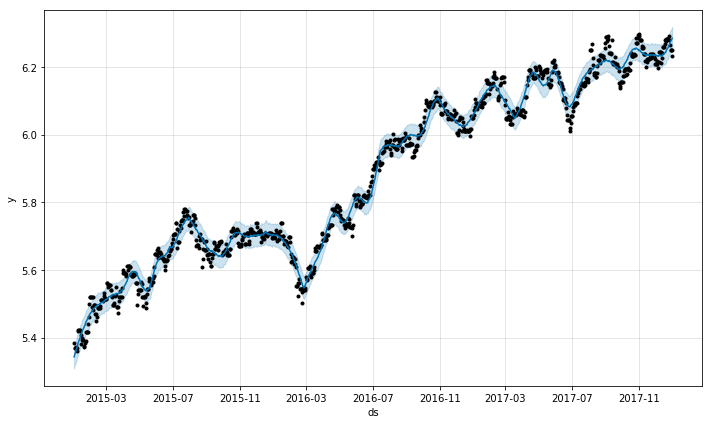

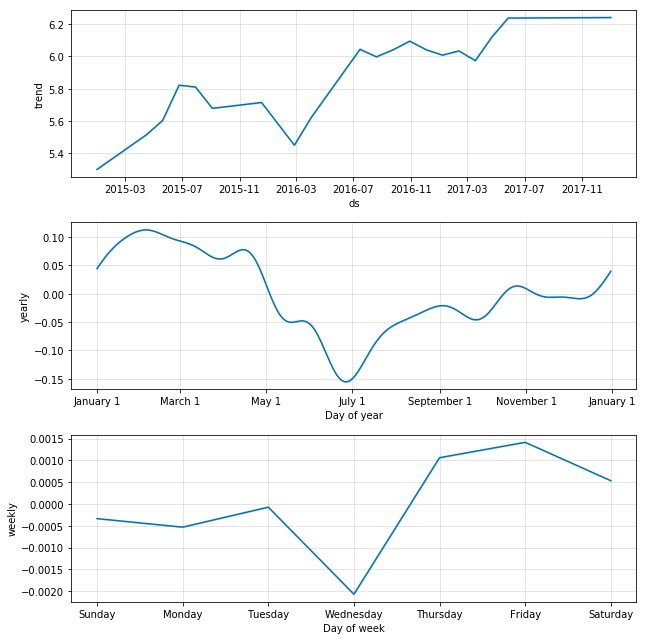

In [84]:
# Calling functions from Technical_Indicators file

stock1_df = tech_ind.pcod(stock1_df)
stock1_df = tech_ind.hld(stock1_df)
stock1_df = tech_ind.stockRsi(stock1_df, numOfDays=20)
stock1_df = tech_ind.bbands(stock1_df, length=20, numsd=2) 
stock1_df = tech_ind.stma(stock1_df, numOfDays=20) 
stock1_df = tech_ind.ltma(stock1_df, numOfDays=120) 
stock1_df = tech_ind.ema(stock1_df, numOfDays=20) 
stock1_df = tech_ind.scul(stock1_df)
stock1_df = tech_ind.scll(stock1_df)
stock1_df = tech_ind.stma_cuts_ltma(stock1_df)
stock1_df = tech_ind.close_cuts_stma(stock1_df)
stock1_df = tech_ind.close_cuts_ltma(stock1_df)
stock1_df = tech_ind.daily_returns(stock1_df)
stock1_df = tech_ind.daily_returns_NSE(stock1_df)
stock1_df = tech_ind.daily_returns_SPY(stock1_df)
stock1_df = tech_ind.daily_returns_DOWJONES(stock1_df)
stock1_df = tech_ind.daily_returns_NASDAQ(stock1_df)
stock1_df = tech_ind.price_movement(stock1_df)
stock1_df = tech_ind.beta_values(stock1_df)

#time-series prediction for the stock using prophet
stock1_df.reset_index(inplace = True)
stock1_df = stock1_df.rename(columns={'index':'Date'})
stock1_df, ts_data1 = tech_ind.TS_close_price(stock1_df)

stock1_df = Sdf.retype(stock1_df)
stock1_df['tr'] = stock1_df.get('tr') 
stock1_df['atr'] = stock1_df.get('atr')
stock1_df['wr_10'] = stock1_df.get('wr_10')
stock1_df['kdjk'] = stock1_df.get('kdjk')
stock1_df['macd'] = stock1_df.get('macd')

# Writing the stock1_df data to .csv file
stock1_df.to_csv('{}'.format(tickers_for_model[0]+'.csv'))


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.




0   2015-01-01
1   2015-01-02
2   2015-01-03
3   2015-01-04
4   2015-01-05
Name: ds, dtype: datetime64[ns]


          ds      y_orig
0 2015-01-01  158.449997
1 2015-01-02  160.100006
2 2015-01-03  160.100006
3 2015-01-04  160.100006
4 2015-01-05  156.850006


          ds      y_orig         y
0 2015-01-01  158.449997  5.065439
1 2015-01-02  160.100006  5.075799
2 2015-01-03  160.100006  5.075799
3 2015-01-04  160.100006  5.075799
4 2015-01-05  156.850006  5.055290


             ds      yhat  yhat_lower  yhat_upper
1087 2017-12-23  5.553928    5.496117    5.614855
1088 2017-12-24  5.553991    5.491610    5.612163
1089 2017-12-25  5.554790    5.502132    5.612008
1090 2017-12-26  5.554001    5.499504    5.612175
1091 2017-12-27  5.553266    5.497476    5.616262
1092 2017-12-28  5.553078    5.492695    5.610074
1093 2017-12-29  5.550372    5.494196    5.606526
1094 2017-12-30  5.547664    5.489016    5.607444
1095 2017-12-31  5.544542    5.483768    5.603981
1096 2018-01-01  5.542235

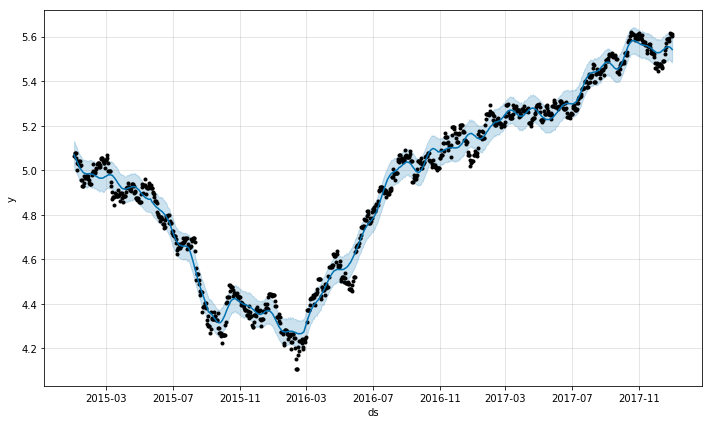

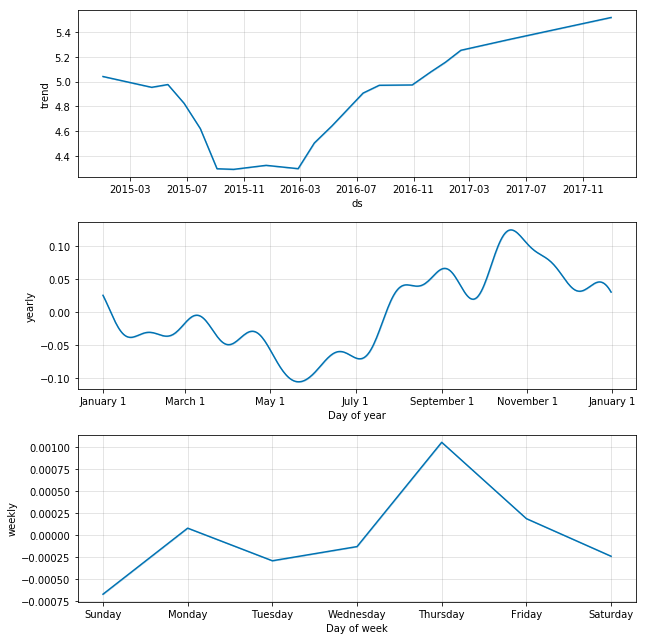

In [85]:
# Calling functions from Technical_Indicators file

stock2_df = tech_ind.pcod(stock2_df)
stock2_df = tech_ind.hld(stock2_df)
stock2_df = tech_ind.stockRsi(stock2_df, numOfDays=20)
stock2_df = tech_ind.bbands(stock2_df, length=20, numsd=2) 
stock2_df = tech_ind.stma(stock2_df, numOfDays=20) 
stock2_df = tech_ind.ltma(stock2_df, numOfDays=120) 
stock2_df = tech_ind.ema(stock2_df, numOfDays=20) 
stock2_df = tech_ind.scul(stock2_df)
stock2_df = tech_ind.scll(stock2_df)
stock2_df = tech_ind.stma_cuts_ltma(stock2_df)
stock2_df = tech_ind.close_cuts_stma(stock2_df)
stock2_df = tech_ind.close_cuts_ltma(stock2_df)
stock2_df = tech_ind.daily_returns(stock2_df)
stock2_df = tech_ind.daily_returns_NSE(stock2_df)
stock2_df = tech_ind.daily_returns_SPY(stock2_df)
stock2_df = tech_ind.daily_returns_DOWJONES(stock2_df)
stock2_df = tech_ind.daily_returns_NASDAQ(stock2_df)
stock2_df = tech_ind.price_movement(stock2_df)
stock2_df = tech_ind.beta_values(stock2_df)

#time-series prediction for the stock using prophet
stock2_df.reset_index(inplace = True)
stock2_df = stock2_df.rename(columns={'index':'Date'})
stock2_df, ts_data1 = tech_ind.TS_close_price(stock2_df)

stock2_df = Sdf.retype(stock2_df)
stock2_df['tr'] = stock2_df.get('tr') 
stock2_df['atr'] = stock2_df.get('atr')
stock2_df['wr_10'] = stock2_df.get('wr_10')
stock2_df['kdjk'] = stock2_df.get('kdjk')
stock2_df['macd'] = stock2_df.get('macd')

# Writing the stock2_df data to .csv file
stock2_df.to_csv('{}'.format(tickers_for_model[1]+'.csv'))


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.




0   2015-01-01
1   2015-01-02
2   2015-01-03
3   2015-01-04
4   2015-01-05
Name: ds, dtype: datetime64[ns]


          ds      y_orig
0 2015-01-01  618.525024
1 2015-01-02  612.325012
2 2015-01-03  612.325012
3 2015-01-04  612.325012
4 2015-01-05  609.224976


          ds      y_orig         y
0 2015-01-01  618.525024  6.427338
1 2015-01-02  612.325012  6.417263
2 2015-01-03  612.325012  6.417263
3 2015-01-04  612.325012  6.417263
4 2015-01-05  609.224976  6.412188


             ds      yhat  yhat_lower  yhat_upper
1087 2017-12-23  6.596780    6.565125    6.627515
1088 2017-12-24  6.597352    6.565829    6.629060
1089 2017-12-25  6.598451    6.569162    6.628414
1090 2017-12-26  6.599467    6.568528    6.631954
1091 2017-12-27  6.601020    6.568369    6.630703
1092 2017-12-28  6.599228    6.565339    6.630277
1093 2017-12-29  6.601359    6.569117    6.633091
1094 2017-12-30  6.602087    6.567354    6.635305
1095 2017-12-31  6.602864    6.569037    6.633317
1096 2018-01-01  6.604269

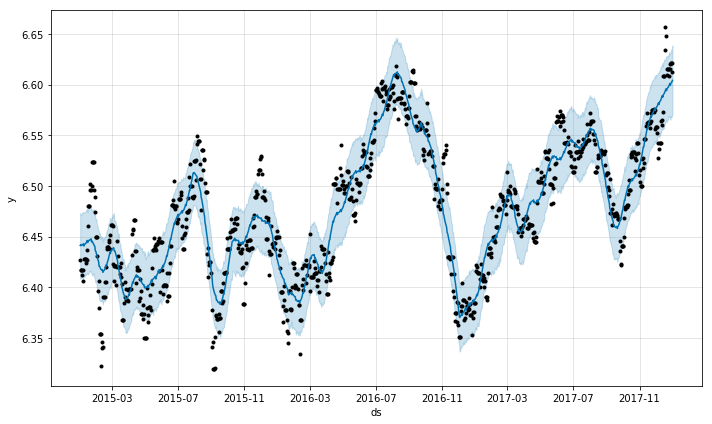

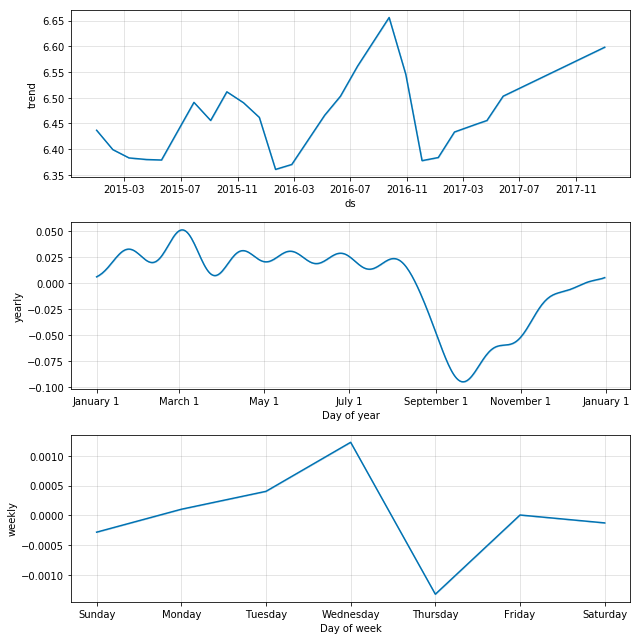

In [86]:
# Calling functions from Technical_Indicators file

stock3_df = tech_ind.pcod(stock3_df)
stock3_df = tech_ind.hld(stock3_df)
stock3_df = tech_ind.stockRsi(stock3_df, numOfDays=20)
stock3_df = tech_ind.bbands(stock3_df, length=20, numsd=2) 
stock3_df = tech_ind.stma(stock3_df, numOfDays=20) 
stock3_df = tech_ind.ltma(stock3_df, numOfDays=120) 
stock3_df = tech_ind.ema(stock3_df, numOfDays=20) 
stock3_df = tech_ind.scul(stock3_df)
stock3_df = tech_ind.scll(stock3_df)
stock3_df = tech_ind.stma_cuts_ltma(stock3_df)
stock3_df = tech_ind.close_cuts_stma(stock3_df)
stock3_df = tech_ind.close_cuts_ltma(stock3_df)
stock3_df = tech_ind.daily_returns(stock3_df)
stock3_df = tech_ind.daily_returns_NSE(stock3_df)
stock3_df = tech_ind.daily_returns_SPY(stock3_df)
stock3_df = tech_ind.daily_returns_DOWJONES(stock3_df)
stock3_df = tech_ind.daily_returns_NASDAQ(stock3_df)
stock3_df = tech_ind.price_movement(stock3_df)
stock3_df = tech_ind.beta_values(stock3_df)

#time-series prediction for the stock using prophet
stock3_df.reset_index(inplace = True)
stock3_df = stock3_df.rename(columns={'index':'Date'})
stock3_df, ts_data1 = tech_ind.TS_close_price(stock3_df)

stock3_df = Sdf.retype(stock3_df)
stock3_df['tr'] = stock3_df.get('tr') 
stock3_df['atr'] = stock3_df.get('atr')
stock3_df['wr_10'] = stock3_df.get('wr_10')
stock3_df['kdjk'] = stock3_df.get('kdjk')
stock3_df['macd'] = stock3_df.get('macd')

# Writing the stock3_df data to .csv file
stock3_df.to_csv('{}'.format(tickers_for_model[2]+'.csv'))


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.




0   2015-01-01
1   2015-01-02
2   2015-01-03
3   2015-01-04
4   2015-01-05
Name: ds, dtype: datetime64[ns]


          ds      y_orig
0 2015-01-01  276.200012
1 2015-01-02  278.649994
2 2015-01-03  278.649994
3 2015-01-04  278.649994
4 2015-01-05  279.149994


          ds      y_orig         y
0 2015-01-01  276.200012  5.621125
1 2015-01-02  278.649994  5.629956
2 2015-01-03  278.649994  5.629956
3 2015-01-04  278.649994  5.629956
4 2015-01-05  279.149994  5.631749


             ds      yhat  yhat_lower  yhat_upper
1087 2017-12-23  5.702066    5.677876    5.725716
1088 2017-12-24  5.703974    5.677044    5.729123
1089 2017-12-25  5.706656    5.680425    5.733022
1090 2017-12-26  5.709065    5.685612    5.734943
1091 2017-12-27  5.711930    5.689107    5.738642
1092 2017-12-28  5.713385    5.690121    5.736298
1093 2017-12-29  5.714962    5.689226    5.738805
1094 2017-12-30  5.716953    5.692125    5.740867
1095 2017-12-31  5.718882    5.692987    5.743931
1096 2018-01-01  5.721446

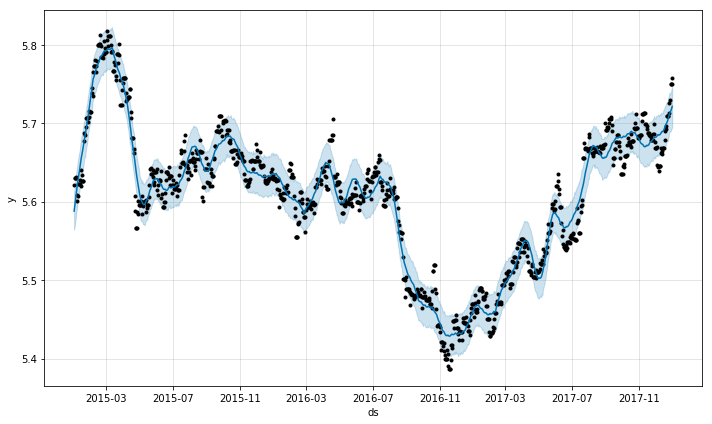

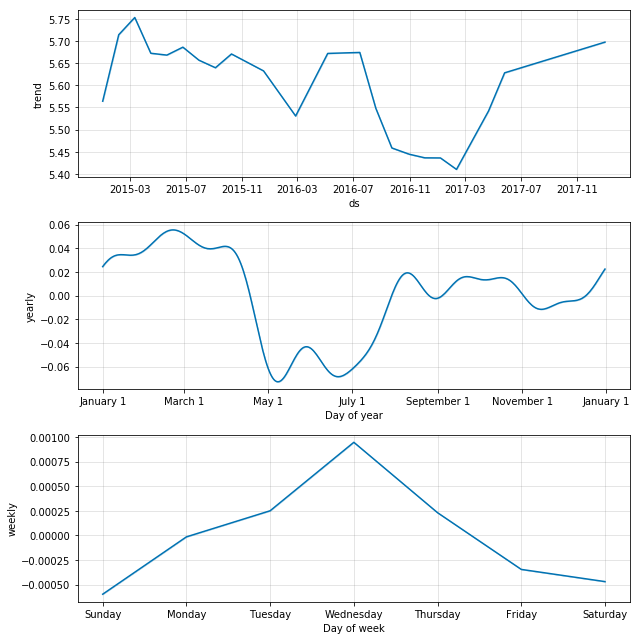

In [87]:
# Calling functions from Technical_Indicators file

stock4_df = tech_ind.pcod(stock4_df)
stock4_df = tech_ind.hld(stock4_df)
stock4_df = tech_ind.stockRsi(stock4_df, numOfDays=20)
stock4_df = tech_ind.bbands(stock4_df, length=20, numsd=2) 
stock4_df = tech_ind.stma(stock4_df, numOfDays=20) 
stock4_df = tech_ind.ltma(stock4_df, numOfDays=120) 
stock4_df = tech_ind.ema(stock4_df, numOfDays=20) 
stock4_df = tech_ind.scul(stock4_df)
stock4_df = tech_ind.scll(stock4_df)
stock4_df = tech_ind.stma_cuts_ltma(stock4_df)
stock4_df = tech_ind.close_cuts_stma(stock4_df)
stock4_df = tech_ind.close_cuts_ltma(stock4_df)
stock4_df = tech_ind.daily_returns(stock4_df)
stock4_df = tech_ind.daily_returns_NSE(stock4_df)
stock4_df = tech_ind.daily_returns_SPY(stock4_df)
stock4_df = tech_ind.daily_returns_DOWJONES(stock4_df)
stock4_df = tech_ind.daily_returns_NASDAQ(stock4_df)
stock4_df = tech_ind.price_movement(stock4_df)
stock4_df = tech_ind.beta_values(stock4_df)

#time-series prediction for the stock using prophet
stock4_df.reset_index(inplace = True)
stock4_df = stock4_df.rename(columns={'index':'Date'})
stock4_df, ts_data1 = tech_ind.TS_close_price(stock4_df)

stock4_df = Sdf.retype(stock4_df)
stock4_df['tr'] = stock4_df.get('tr') 
stock4_df['atr'] = stock4_df.get('atr')
stock4_df['wr_10'] = stock4_df.get('wr_10')
stock4_df['kdjk'] = stock4_df.get('kdjk')
stock4_df['macd'] = stock4_df.get('macd')

# Writing the stock4_df data to .csv file
stock4_df.to_csv('{}'.format(tickers_for_model[3]+'.csv'))


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.




0   2015-01-01
1   2015-01-02
2   2015-01-03
3   2015-01-04
4   2015-01-05
Name: ds, dtype: datetime64[ns]


          ds      y_orig
0 2015-01-01  319.549988
1 2015-01-02  319.350006
2 2015-01-03  319.350006
3 2015-01-04  319.350006
4 2015-01-05  323.799988


          ds      y_orig         y
0 2015-01-01  319.549988  5.766914
1 2015-01-02  319.350006  5.766288
2 2015-01-03  319.350006  5.766288
3 2015-01-04  319.350006  5.766288
4 2015-01-05  323.799988  5.780126


             ds      yhat  yhat_lower  yhat_upper
1087 2017-12-23  6.000543    5.950796    6.050878
1088 2017-12-24  6.000843    5.954774    6.046587
1089 2017-12-25  6.001737    5.953480    6.048045
1090 2017-12-26  6.003900    5.956210    6.049023
1091 2017-12-27  6.003734    5.954705    6.049675
1092 2017-12-28  6.004368    5.956328    6.052808
1093 2017-12-29  6.005764    5.956714    6.049802
1094 2017-12-30  6.006891    5.955181    6.052631
1095 2017-12-31  6.008149    5.958544    6.055308
1096 2018-01-01  6.010001

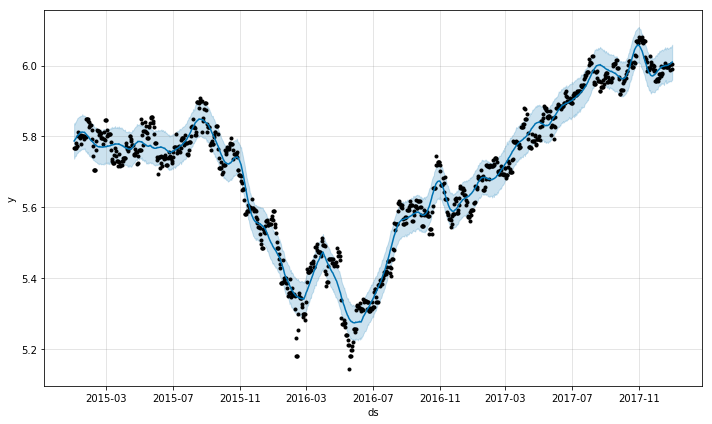

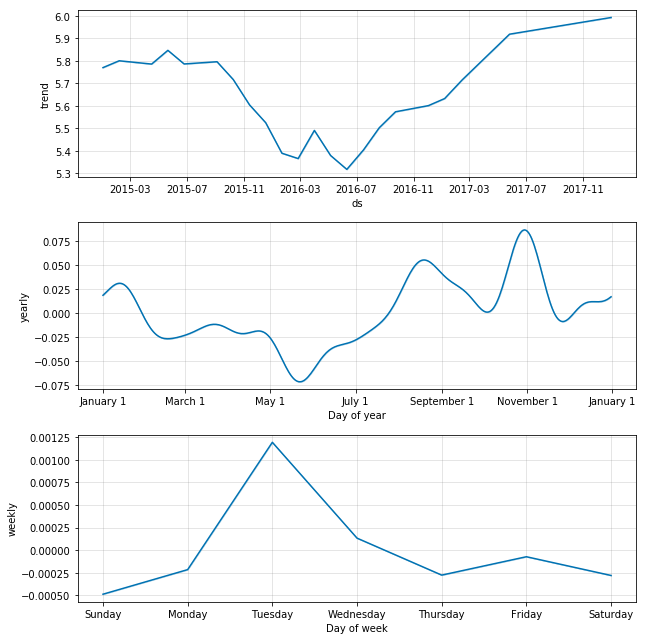

In [88]:
# Calling functions from Technical_Indicators file

stock5_df = tech_ind.pcod(stock5_df)
stock5_df = tech_ind.hld(stock5_df)
stock5_df = tech_ind.stockRsi(stock5_df, numOfDays=20)
stock5_df = tech_ind.bbands(stock5_df, length=20, numsd=2) 
stock5_df = tech_ind.stma(stock5_df, numOfDays=20) 
stock5_df = tech_ind.ltma(stock5_df, numOfDays=120) 
stock5_df = tech_ind.ema(stock5_df, numOfDays=20) 
stock5_df = tech_ind.scul(stock5_df)
stock5_df = tech_ind.scll(stock5_df)
stock5_df = tech_ind.stma_cuts_ltma(stock5_df)
stock5_df = tech_ind.close_cuts_stma(stock5_df)
stock5_df = tech_ind.close_cuts_ltma(stock5_df)
stock5_df = tech_ind.daily_returns(stock5_df)
stock5_df = tech_ind.daily_returns_NSE(stock5_df)
stock5_df = tech_ind.daily_returns_SPY(stock5_df)
stock5_df = tech_ind.daily_returns_DOWJONES(stock5_df)
stock5_df = tech_ind.daily_returns_NASDAQ(stock5_df)
stock5_df = tech_ind.price_movement(stock5_df)
stock5_df = tech_ind.beta_values(stock5_df)

#time-series prediction for the stock using prophet
stock5_df.reset_index(inplace = True)
stock5_df = stock5_df.rename(columns={'index':'Date'})
stock5_df, ts_data1 = tech_ind.TS_close_price(stock5_df)

stock5_df = Sdf.retype(stock5_df)
stock5_df['tr'] = stock5_df.get('tr') 
stock5_df['atr'] = stock5_df.get('atr')
stock5_df['wr_10'] = stock5_df.get('wr_10')
stock5_df['kdjk'] = stock5_df.get('kdjk')
stock5_df['macd'] = stock5_df.get('macd')

# Writing the stock5_df data to .csv file
stock5_df.to_csv('{}'.format(tickers_for_model[4]+'.csv'))


# Continue below steps till the end of the notebook....for each stock

### Visualization and outliers treatment for Stock-1

In [89]:
stock1_df.head()

,open,high,low,close,adj close,volume,vwap,nse,spy,dj,...,kdjk,kdjd_9,kdjd,kdjj_9,kdjj,close_12_ema,close_26_ema,macd,macds,macdh
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,216.300003,219.167007,214.067001,218.067001,168.424866,1446501.0,650.33,8395.450195,2058.199951,17832.990234,...,59.477093,53.159031,53.159031,72.113218,72.113218,218.067001,218.067001,0.000000,0.000000,0.000000
2015-01-02,216.966995,218.632996,214.149994,214.800003,165.901581,3071145.0,648.43,8395.450195,2058.199951,17832.990234,...,44.442253,50.253438,50.253438,32.819882,32.819882,216.297377,216.370675,-0.073298,-0.040721,-0.065154
2015-01-03,216.966995,218.632996,214.149994,214.800003,165.901581,3071145.0,648.43,8395.450195,2058.199951,17832.990234,...,34.419026,44.975301,44.975301,13.306475,13.306475,215.712952,215.806348,-0.093396,-0.062309,-0.062174
2015-01-04,216.966995,218.632996,214.149994,214.800003,165.901581,3071145.0,648.43,8395.450195,2058.199951,17832.990234,...,27.736874,39.229159,39.229159,4.752305,4.752305,215.424769,215.525018,-0.100248,-0.075161,-0.050174
2015-01-05,215.000000,216.483002,213.766998,215.216995,166.223648,3283116.0,645.09,8378.400391,2020.579956,17501.650391,...,27.441833,35.300050,35.300050,11.725400,11.725400,215.368318,215.453586,-0.085268,-0.078168,-0.014201


In [90]:
stock1_df.columns

Index(['open', 'high', 'low', 'close', 'adj close', 'volume', 'vwap', 'nse',
       'spy', 'dj', 'nasdaq', 'pcod', 'hld', 'rsi', 'bbul', 'bbll', 'stma',
       'ltma', 'ema', 'scul', 'scll', 'stma_cut_ltma_b', 'stma_cut_ltma_a',
       'close_pr_cut_stma_b', 'close_pr_cut_stma_a', 'close_pr_cut_ltma_b',
       'close_pr_cut_ltma_a', 'dr_stock', 'dr_nse', 'dr_spy', 'dr_dj',
       'dr_nasdaq', 'price_movmnt', 'beta', 'ds', 'ts_close_pr', 'close_-1_s',
       'tr', 'atr', 'wr_10', 'rsv_9', 'kdjk_9', 'kdjk', 'kdjd_9', 'kdjd',
       'kdjj_9', 'kdjj', 'close_12_ema', 'close_26_ema', 'macd', 'macds',
       'macdh'],
      dtype='object')

In [91]:
stock1_df.drop(['ds', 'close_-1_s', 'rsv_9', 'kdjk_9', 'kdjd_9', 'kdjj_9', 'close_12_ema', 'close_26_ema'], axis=1, inplace=True)

In [92]:
stock1_df.columns

Index(['open', 'high', 'low', 'close', 'adj close', 'volume', 'vwap', 'nse',
       'spy', 'dj', 'nasdaq', 'pcod', 'hld', 'rsi', 'bbul', 'bbll', 'stma',
       'ltma', 'ema', 'scul', 'scll', 'stma_cut_ltma_b', 'stma_cut_ltma_a',
       'close_pr_cut_stma_b', 'close_pr_cut_stma_a', 'close_pr_cut_ltma_b',
       'close_pr_cut_ltma_a', 'dr_stock', 'dr_nse', 'dr_spy', 'dr_dj',
       'dr_nasdaq', 'price_movmnt', 'beta', 'ts_close_pr', 'tr', 'atr',
       'wr_10', 'kdjk', 'kdjd', 'kdjj', 'macd', 'macds', 'macdh'],
      dtype='object')

In [93]:
stock1_df.head(50)

,open,high,low,close,adj close,volume,vwap,nse,spy,dj,...,ts_close_pr,tr,atr,wr_10,kdjk,kdjd,kdjj,macd,macds,macdh
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,216.300003,219.167007,214.067001,218.067001,168.424866,1446501.0,650.33,8395.450195,2058.199951,17832.990234,...,209.210160,NaN,NaN,21.568720,59.477093,53.159031,72.113218,0.000000,0.000000,0.000000
2015-01-02,216.966995,218.632996,214.149994,214.800003,165.901581,3071145.0,648.43,8395.450195,2058.199951,17832.990234,...,210.488420,4.483002,4.483002,85.627429,44.442253,50.253438,32.819882,-0.073298,-0.040721,-0.065154
2015-01-03,216.966995,218.632996,214.149994,214.800003,165.901581,3071145.0,648.43,8395.450195,2058.199951,17832.990234,...,211.502996,4.483002,4.483002,85.627429,34.419026,44.975301,13.306475,-0.093396,-0.062309,-0.062174
2015-01-04,216.966995,218.632996,214.149994,214.800003,165.901581,3071145.0,648.43,8395.450195,2058.199951,17832.990234,...,212.509926,4.483002,4.483002,85.627429,27.736874,39.229159,4.752305,-0.100248,-0.075161,-0.050174
2015-01-05,215.000000,216.483002,213.766998,215.216995,166.223648,3283116.0,645.09,8378.400391,2020.579956,17501.650391,...,213.647609,2.716004,3.991004,73.148248,27.441833,35.300050,11.725400,-0.085268,-0.078168,-0.014201
2015-01-06,217.466995,218.432999,210.000000,213.050003,164.549973,6560505.0,644.43,8127.350098,2002.609985,17371.640625,...,214.910971,8.432999,5.015700,66.728475,29.385064,33.328388,21.498415,-0.167322,-0.102334,-0.129977
2015-01-07,212.332993,216.449997,212.332993,214.983002,166.042938,3928182.0,644.83,8102.100098,2025.900024,17584.519531,...,215.628363,4.117004,4.836866,45.641996,37.709377,34.788718,43.550696,-0.129494,-0.109207,-0.040574
2015-01-08,216.332993,227.300003,216.332993,225.867004,174.449234,8420097.0,669.86,8234.599609,2062.139893,17907.869141,...,217.434996,12.317001,6.156963,8.283230,55.711841,41.763092,83.609340,0.415594,0.016912,0.797363
2015-01-09,228.000000,229.332993,224.167007,226.449997,174.899506,5039577.0,681.47,8284.500000,2044.810059,17737.369141,...,218.622318,5.165986,5.998701,14.912311,65.503791,49.676658,97.158055,0.815658,0.201427,1.228463


In [94]:
temp_stock1 = stock1_df.copy(deep=True)
temp_stock1.head()

,open,high,low,close,adj close,volume,vwap,nse,spy,dj,...,ts_close_pr,tr,atr,wr_10,kdjk,kdjd,kdjj,macd,macds,macdh
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,216.300003,219.167007,214.067001,218.067001,168.424866,1446501.0,650.33,8395.450195,2058.199951,17832.990234,...,209.210160,NaN,NaN,21.568720,59.477093,53.159031,72.113218,0.000000,0.000000,0.000000
2015-01-02,216.966995,218.632996,214.149994,214.800003,165.901581,3071145.0,648.43,8395.450195,2058.199951,17832.990234,...,210.488420,4.483002,4.483002,85.627429,44.442253,50.253438,32.819882,-0.073298,-0.040721,-0.065154
2015-01-03,216.966995,218.632996,214.149994,214.800003,165.901581,3071145.0,648.43,8395.450195,2058.199951,17832.990234,...,211.502996,4.483002,4.483002,85.627429,34.419026,44.975301,13.306475,-0.093396,-0.062309,-0.062174
2015-01-04,216.966995,218.632996,214.149994,214.800003,165.901581,3071145.0,648.43,8395.450195,2058.199951,17832.990234,...,212.509926,4.483002,4.483002,85.627429,27.736874,39.229159,4.752305,-0.100248,-0.075161,-0.050174
2015-01-05,215.000000,216.483002,213.766998,215.216995,166.223648,3283116.0,645.09,8378.400391,2020.579956,17501.650391,...,213.647609,2.716004,3.991004,73.148248,27.441833,35.300050,11.725400,-0.085268,-0.078168,-0.014201


In [95]:
# Summary statistics of numeric data

temp_stock1.describe().T

,count,mean,std,min,25%,50%,75%,max
open,1097.0,3.702703e+02,9.328539e+01,212.332993,2.905000e+02,3.583330e+02,4.514000e+02,5.449000e+02
high,1097.0,3.751160e+02,9.419956e+01,216.449997,2.946670e+02,3.674330e+02,4.580000e+02,5.515500e+02
low,1097.0,3.650540e+02,9.184616e+01,210.000000,2.870000e+02,3.556670e+02,4.470000e+02,5.355000e+02
close,1097.0,3.700038e+02,9.323703e+01,213.050003,2.898500e+02,3.639830e+02,4.526670e+02,5.428500e+02
adj close,1097.0,3.342215e+02,1.077030e+02,164.549973,2.401875e+02,3.373170e+02,4.316126e+02,5.258688e+02
volume,1097.0,3.981821e+06,2.530520e+06,206300.000000,2.588514e+06,3.347871e+06,4.797027e+06,3.841945e+07
vwap,1097.0,7.347054e+02,1.551625e+02,458.530000,6.175600e+02,7.279100e+02,8.768000e+02,1.137040e+03
nse,1097.0,8.657477e+03,8.286315e+02,6970.600098,8.074100e+03,8.532850e+03,9.150800e+03,1.053150e+04
spy,1097.0,2.201337e+03,1.988101e+02,1829.079956,2.065950e+03,2.125770e+03,2.365450e+03,2.690160e+03
dj,1097.0,1.908807e+04,2.140984e+03,15660.179688,1.768509e+04,1.813572e+04,2.080484e+04,2.483751e+04


In [96]:
temp_stock1.columns

Index(['open', 'high', 'low', 'close', 'adj close', 'volume', 'vwap', 'nse',
       'spy', 'dj', 'nasdaq', 'pcod', 'hld', 'rsi', 'bbul', 'bbll', 'stma',
       'ltma', 'ema', 'scul', 'scll', 'stma_cut_ltma_b', 'stma_cut_ltma_a',
       'close_pr_cut_stma_b', 'close_pr_cut_stma_a', 'close_pr_cut_ltma_b',
       'close_pr_cut_ltma_a', 'dr_stock', 'dr_nse', 'dr_spy', 'dr_dj',
       'dr_nasdaq', 'price_movmnt', 'beta', 'ts_close_pr', 'tr', 'atr',
       'wr_10', 'kdjk', 'kdjd', 'kdjj', 'macd', 'macds', 'macdh'],
      dtype='object')

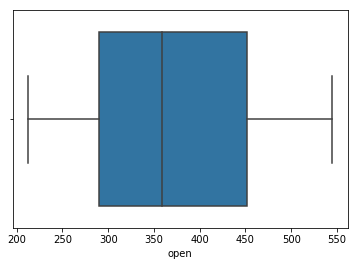

In [97]:
sns.boxplot(x='open', data=temp_stock1)

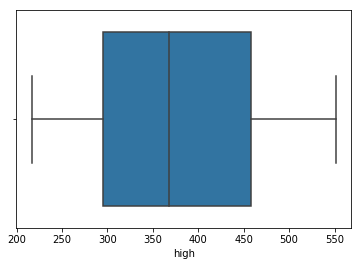

In [98]:
sns.boxplot(x='high', data=temp_stock1)

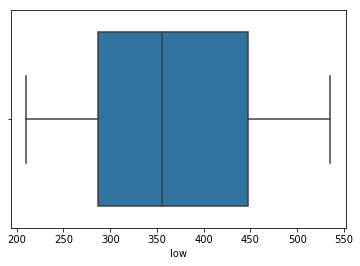

In [99]:
sns.boxplot(x='low', data=temp_stock1)

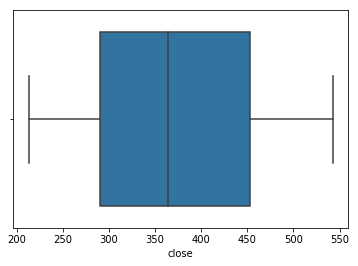

In [100]:
sns.boxplot(x='close', data=temp_stock1)

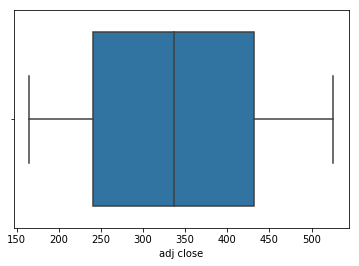

In [101]:
sns.boxplot(x='adj close', data=temp_stock1)

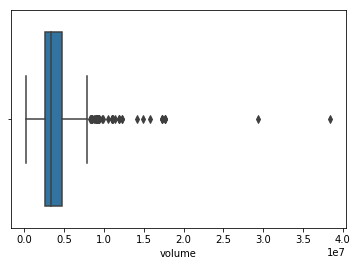

In [102]:
sns.boxplot(x='volume', data=temp_stock1)

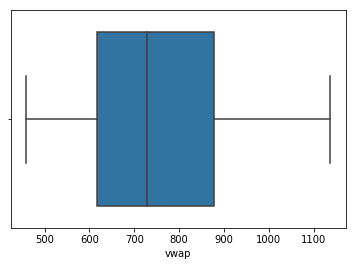

In [103]:
sns.boxplot(x='vwap', data=temp_stock1)

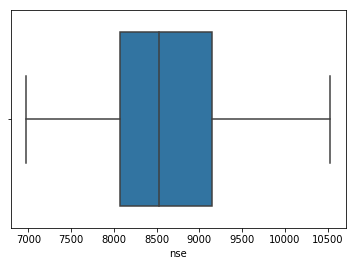

In [104]:
sns.boxplot(x='nse', data=temp_stock1)

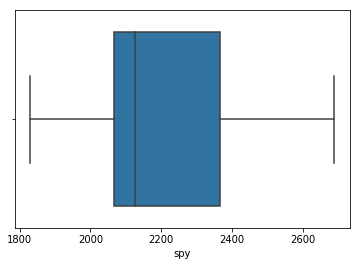

In [105]:
sns.boxplot(x='spy', data=temp_stock1)

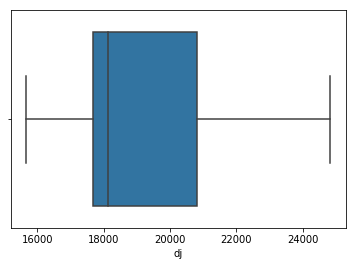

In [106]:
sns.boxplot(x='dj', data=temp_stock1)

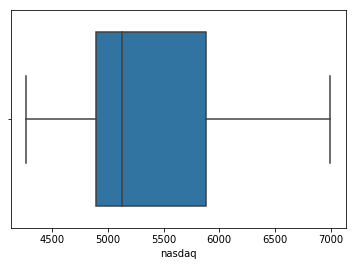

In [107]:
sns.boxplot(x='nasdaq', data=temp_stock1)

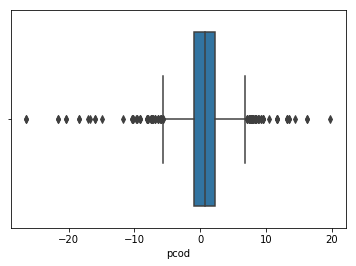

In [108]:
sns.boxplot(x='pcod', data=temp_stock1)

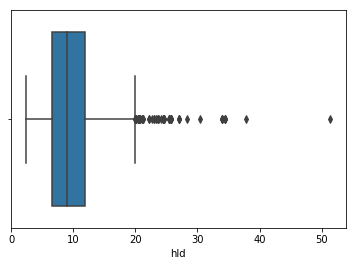

In [109]:
sns.boxplot(x='hld', data=temp_stock1)

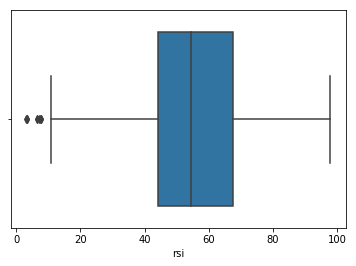

In [110]:
sns.boxplot(x='rsi', data=temp_stock1)

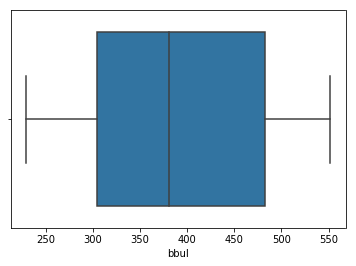

In [111]:
sns.boxplot(x='bbul', data=temp_stock1)

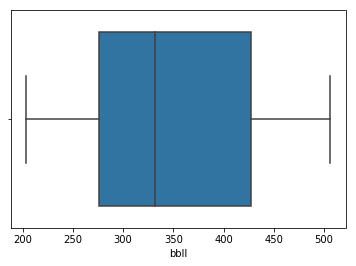

In [112]:
sns.boxplot(x='bbll', data=temp_stock1)

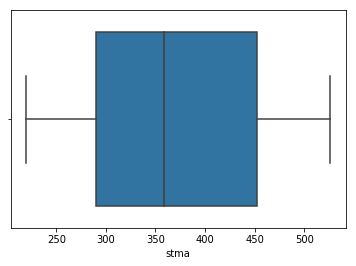

In [113]:
sns.boxplot(x='stma', data=temp_stock1)

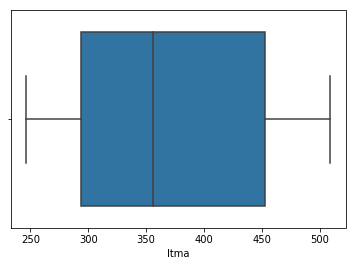

In [114]:
sns.boxplot(x='ltma', data=temp_stock1)

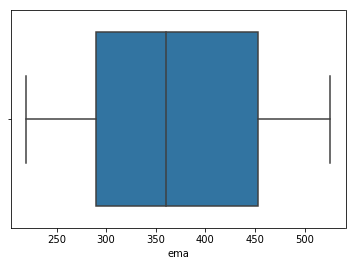

In [115]:
sns.boxplot(x='ema', data=temp_stock1)

In [116]:
temp_stock1['scul'].value_counts()

0    1016
1      81
Name: scul, dtype: int64

In [117]:
temp_stock1['scll'].value_counts()

0    1060
1      37
Name: scll, dtype: int64

In [118]:
temp_stock1['stma_cut_ltma_b'].value_counts()

0    1088
1       9
Name: stma_cut_ltma_b, dtype: int64

In [119]:
temp_stock1['stma_cut_ltma_a'].value_counts()

0    1088
1       9
Name: stma_cut_ltma_a, dtype: int64

In [120]:
temp_stock1['close_pr_cut_stma_b'].value_counts()

0    1041
1      56
Name: close_pr_cut_stma_b, dtype: int64

In [121]:
temp_stock1['close_pr_cut_stma_a'].value_counts()

0    1041
1      56
Name: close_pr_cut_stma_a, dtype: int64

In [122]:
temp_stock1['close_pr_cut_ltma_b'].value_counts()

0    1072
1      25
Name: close_pr_cut_ltma_b, dtype: int64

In [123]:
temp_stock1['close_pr_cut_ltma_a'].value_counts()

0    1072
1      25
Name: close_pr_cut_ltma_a, dtype: int64

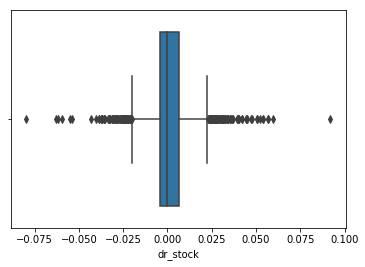

In [124]:
sns.boxplot(x='dr_stock', data=temp_stock1)

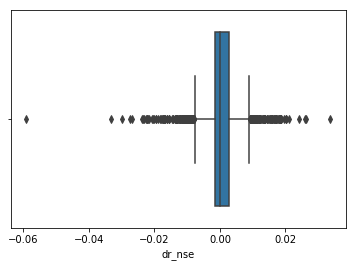

In [125]:
sns.boxplot(x='dr_nse', data=temp_stock1)

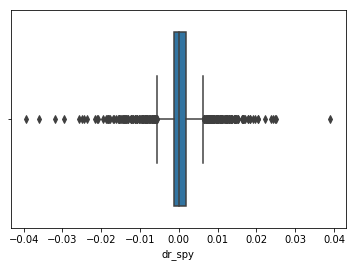

In [126]:
sns.boxplot(x='dr_spy', data=temp_stock1)

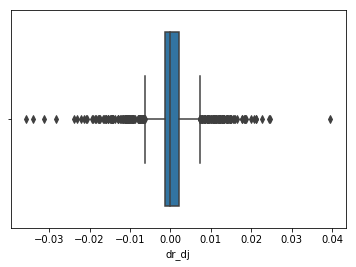

In [127]:
sns.boxplot(x='dr_dj', data=temp_stock1)

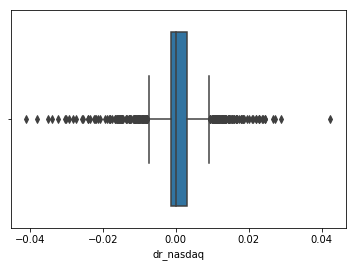

In [128]:
sns.boxplot(x='dr_nasdaq', data=temp_stock1)

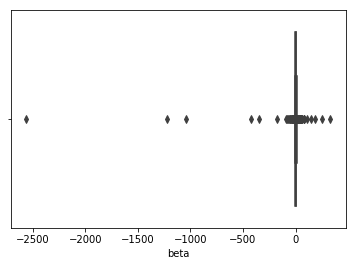

In [129]:
sns.boxplot(x='beta', data=temp_stock1)

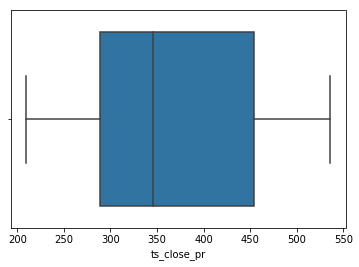

In [130]:
sns.boxplot(x='ts_close_pr', data=temp_stock1)

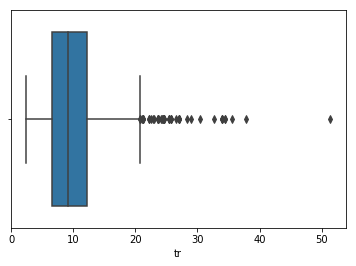

In [131]:
sns.boxplot(x='tr', data=temp_stock1)

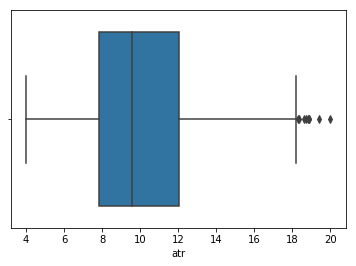

In [132]:
sns.boxplot(x='atr', data=temp_stock1)

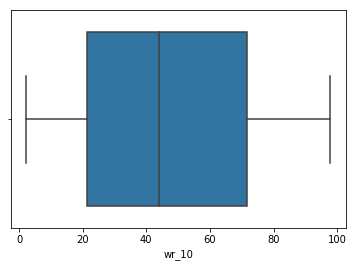

In [133]:
sns.boxplot(x='wr_10', data=temp_stock1)

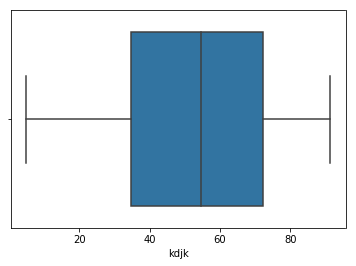

In [134]:
sns.boxplot(x='kdjk', data=temp_stock1)

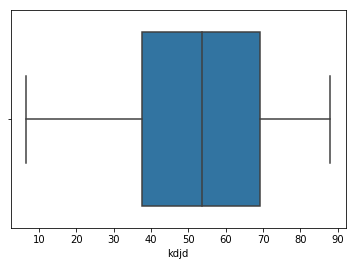

In [135]:
sns.boxplot(x='kdjd', data=temp_stock1)

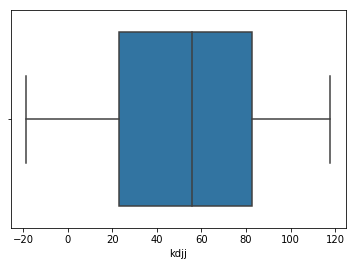

In [136]:
sns.boxplot(x='kdjj', data=temp_stock1)

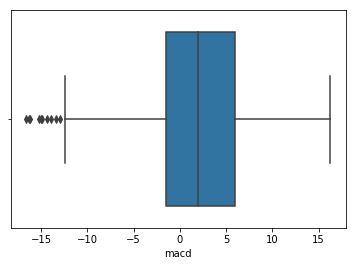

In [137]:
sns.boxplot(x='macd', data=temp_stock1)

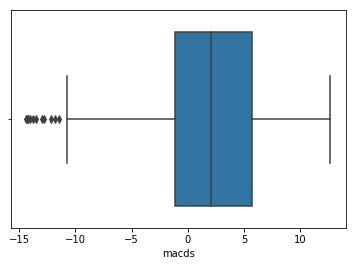

In [138]:
sns.boxplot(x='macds', data=temp_stock1)

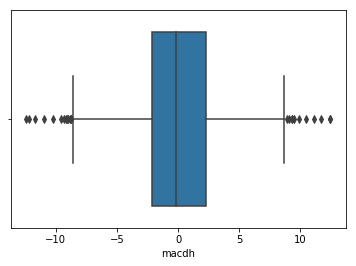

In [139]:
sns.boxplot(x='macdh', data=temp_stock1)

In [140]:
temp_stock1['price_movmnt'].value_counts()

1.0    743
0.0    353
Name: price_movmnt, dtype: int64

In [141]:
temp1 = temp_stock1[['open', 'high', 'low', 'close', 'adj close', 'price_movmnt']] 
temp2 = temp_stock1[['volume', 'vwap', 'nse', 'spy', 'dj', 'price_movmnt']] 
temp3 = temp_stock1[['nasdaq', 'pcod', 'hld', 'rsi', 'stma', 'price_movmnt']] 
temp4 = temp_stock1[['ltma', 'ema', 'dr_stock', 'dr_nse', 'dr_spy', 'price_movmnt']]  
temp5 = temp_stock1[['dr_dj', 'dr_nasdaq', 'beta', 'ts_close_pr', 'tr', 'price_movmnt']] 
temp6 = temp_stock1[['atr','wr_10', 'kdjk', 'kdjd', 'kdjj', 'price_movmnt']]  
temp7 = temp_stock1[['macd', 'macds', 'macdh', 'price_movmnt']] 

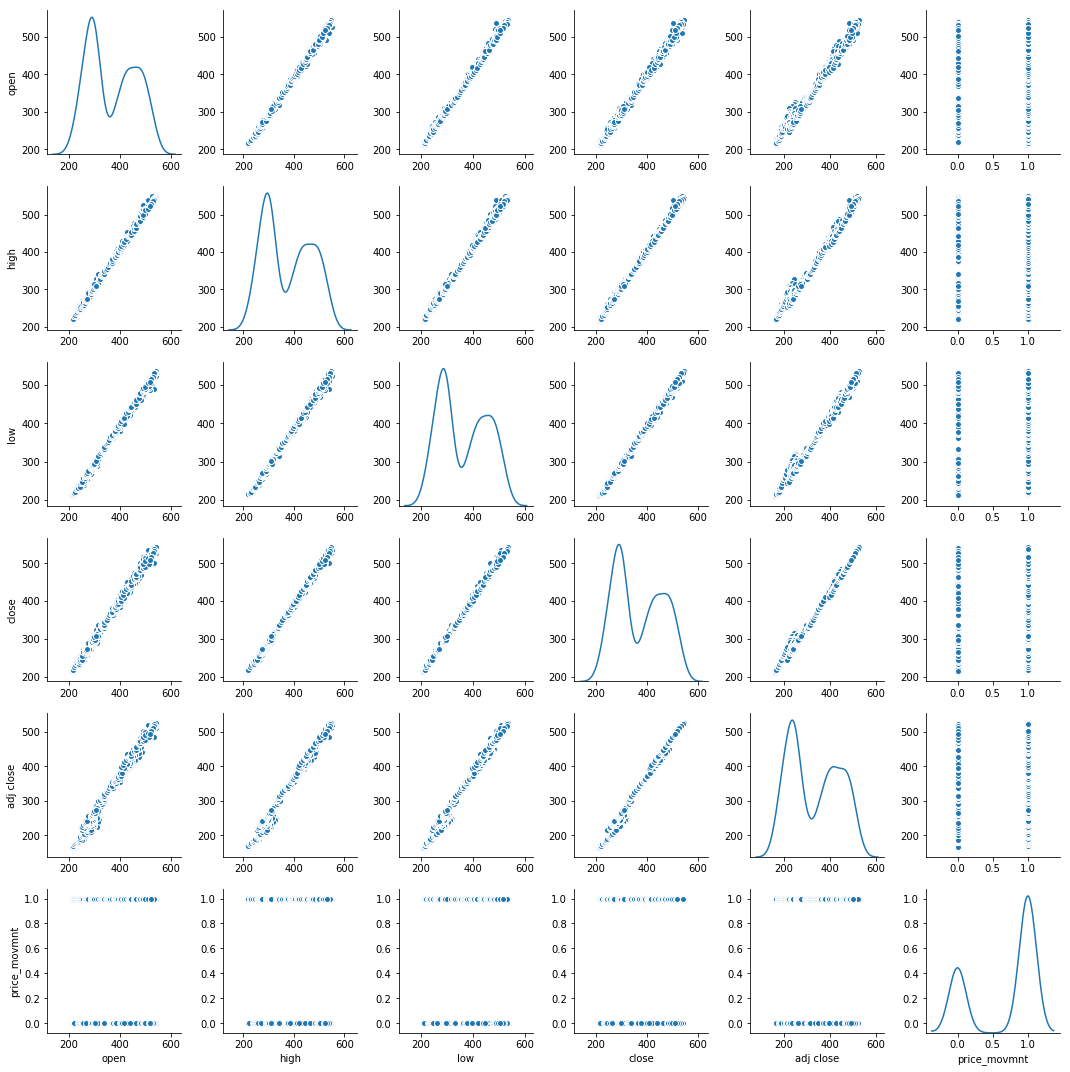

In [142]:
sns.pairplot(temp1, diag_kind='kde')

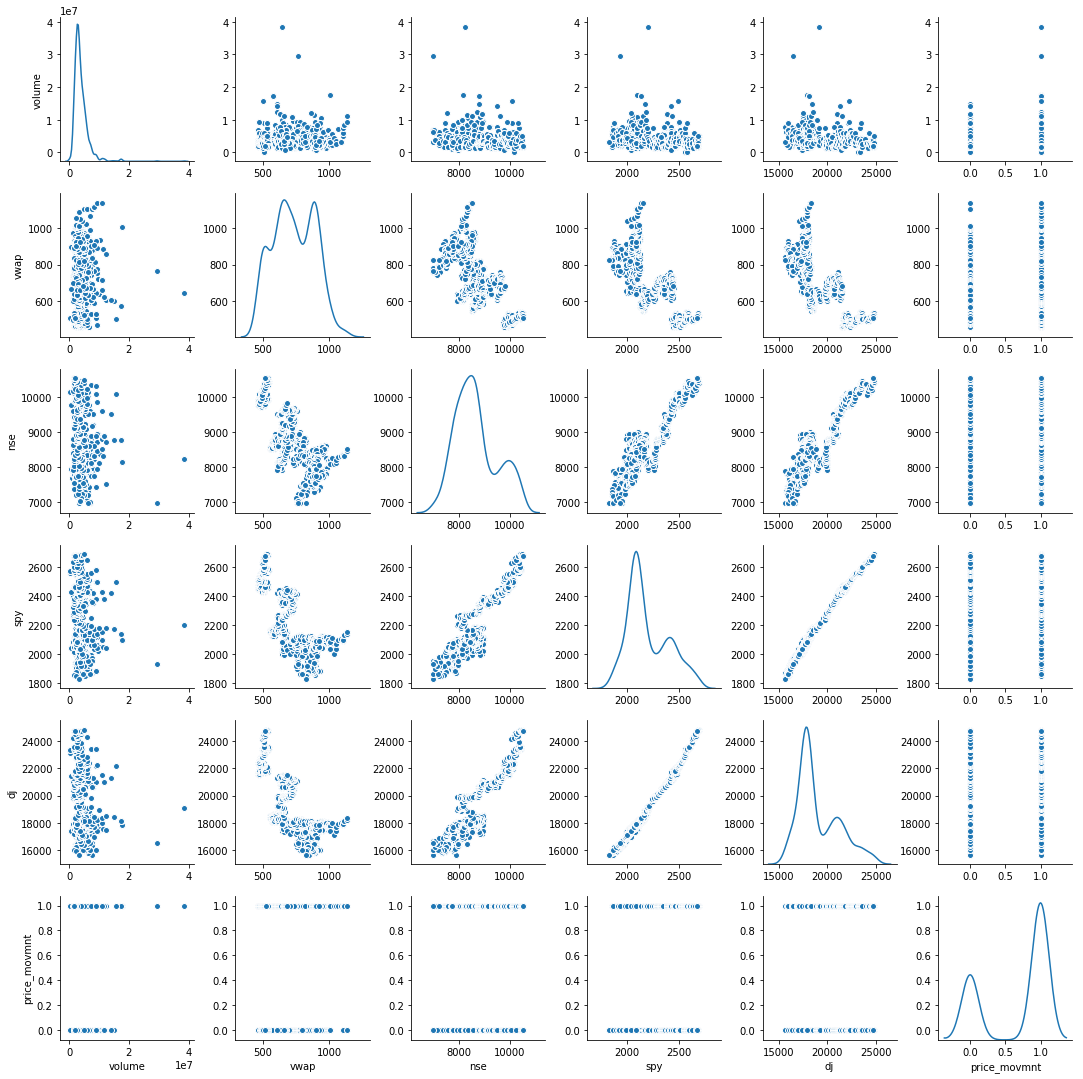

In [143]:
sns.pairplot(temp2, diag_kind='kde')

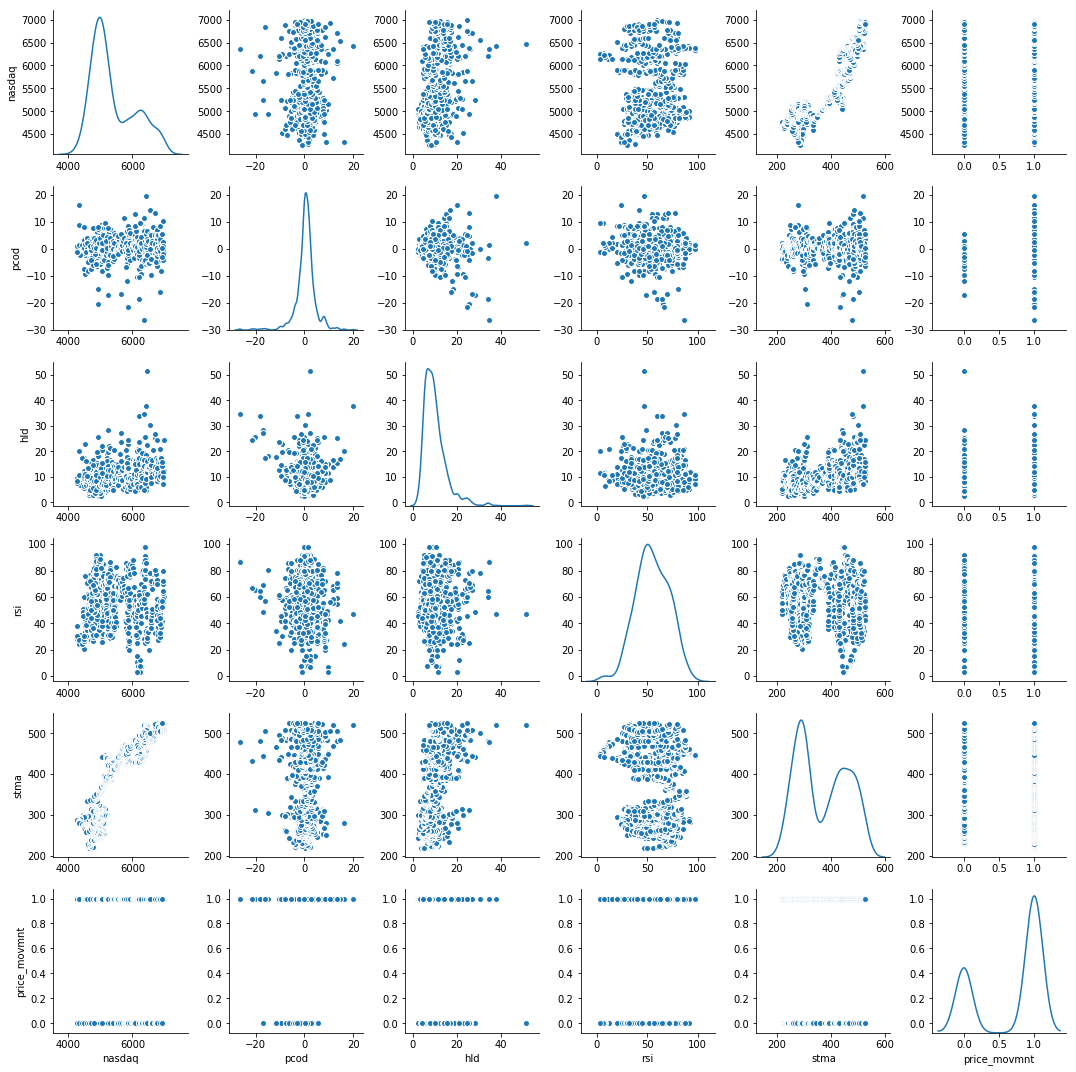

In [144]:
sns.pairplot(temp3, diag_kind='kde')

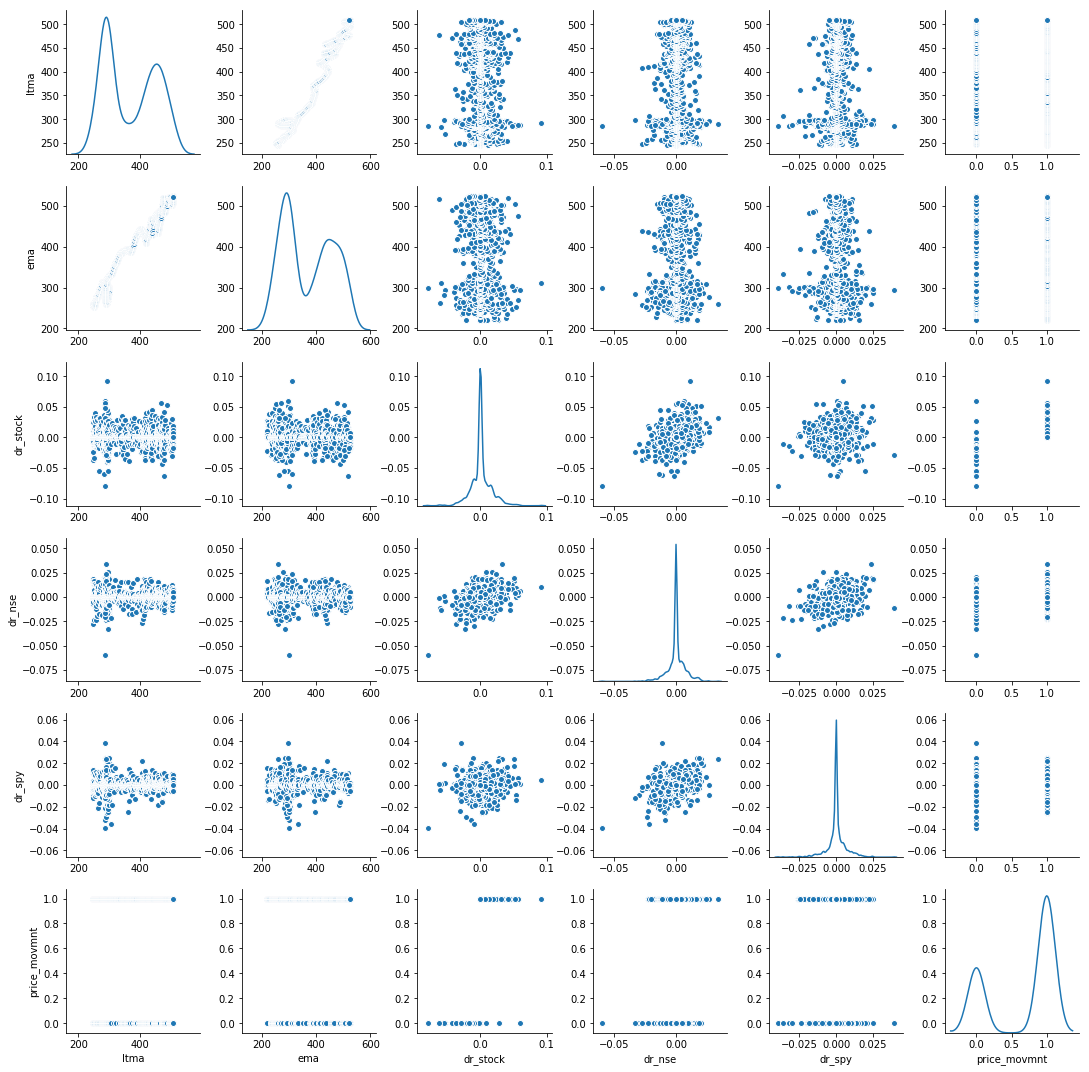

In [145]:
sns.pairplot(temp4, diag_kind='kde')

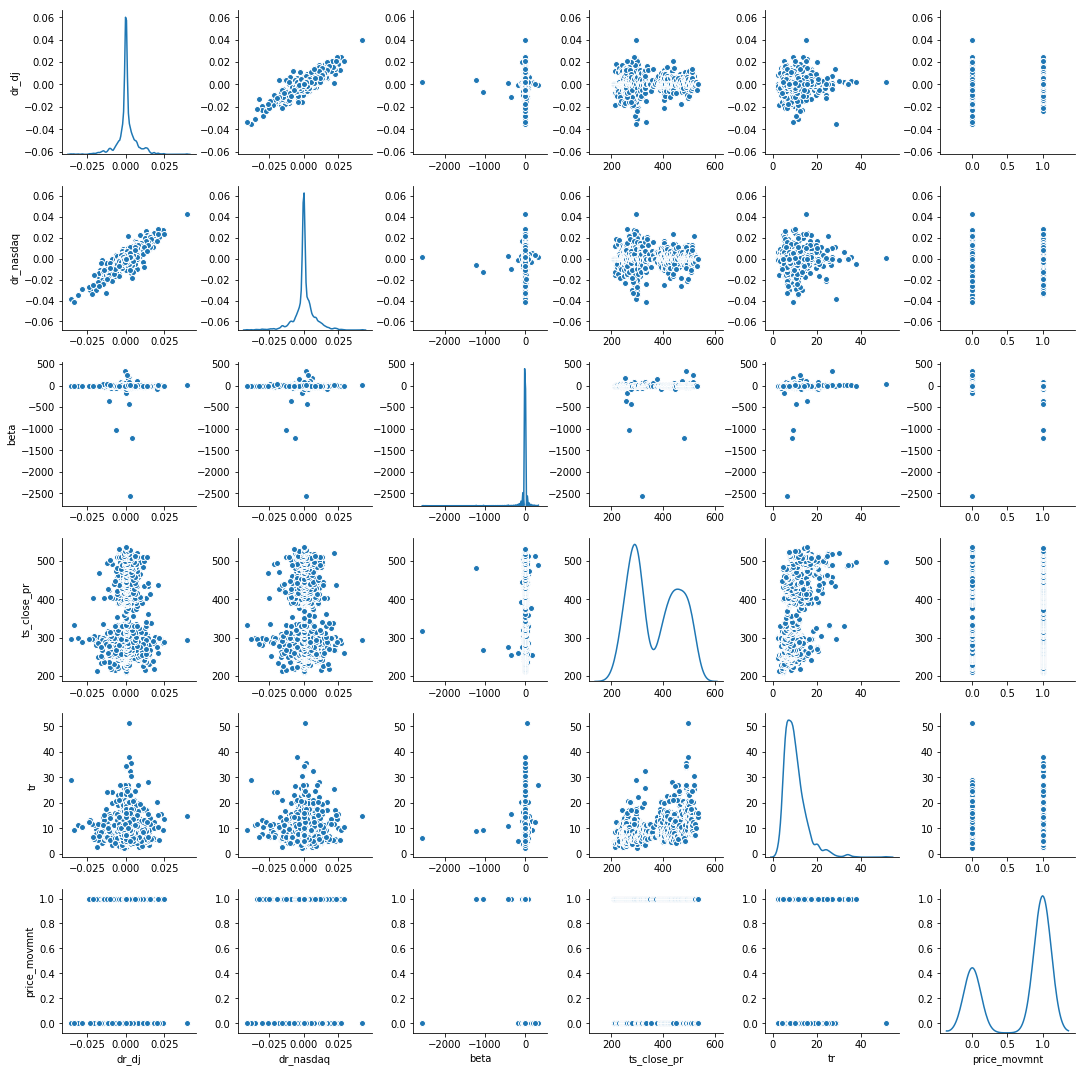

In [146]:
sns.pairplot(temp5, diag_kind='kde')

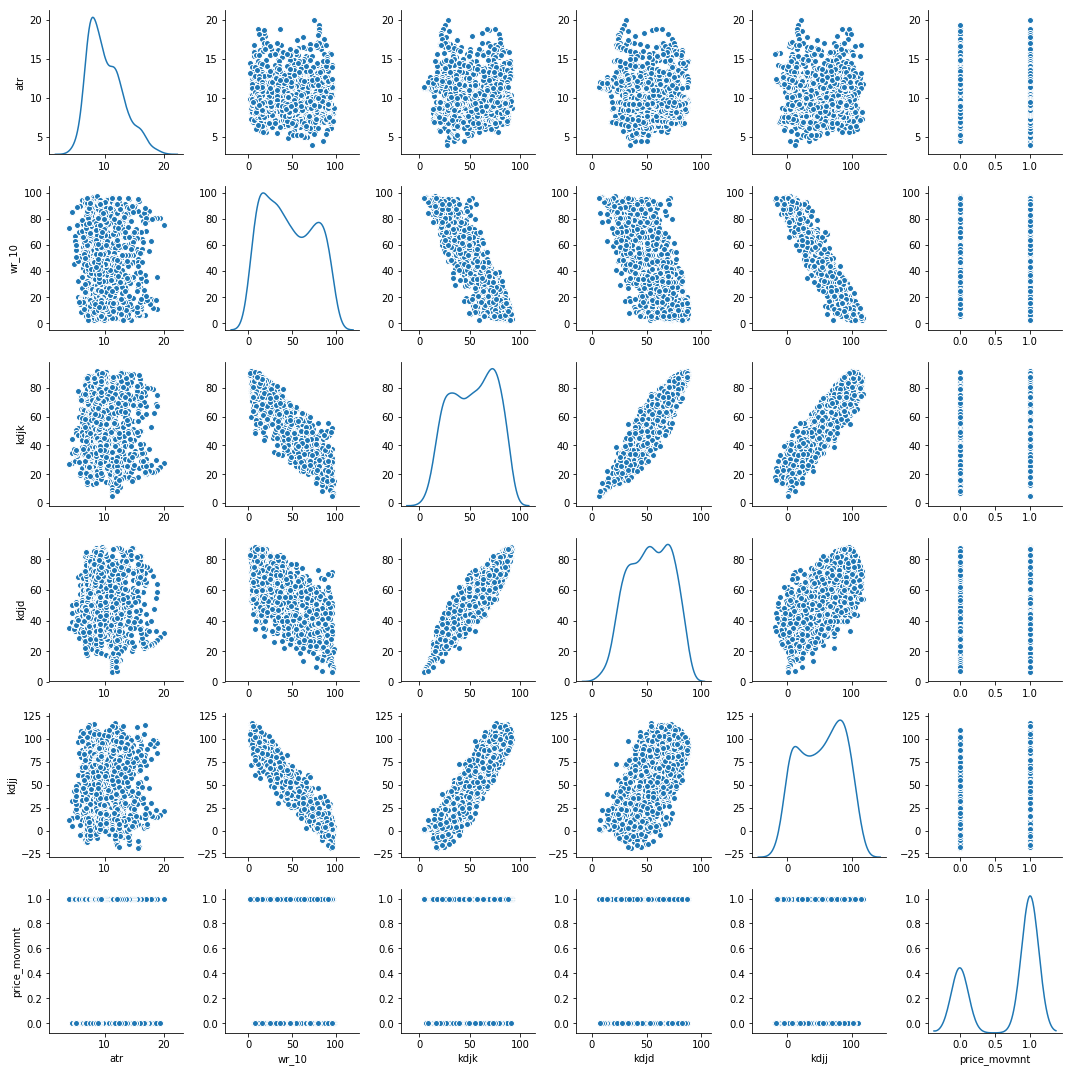

In [147]:
sns.pairplot(temp6, diag_kind='kde')

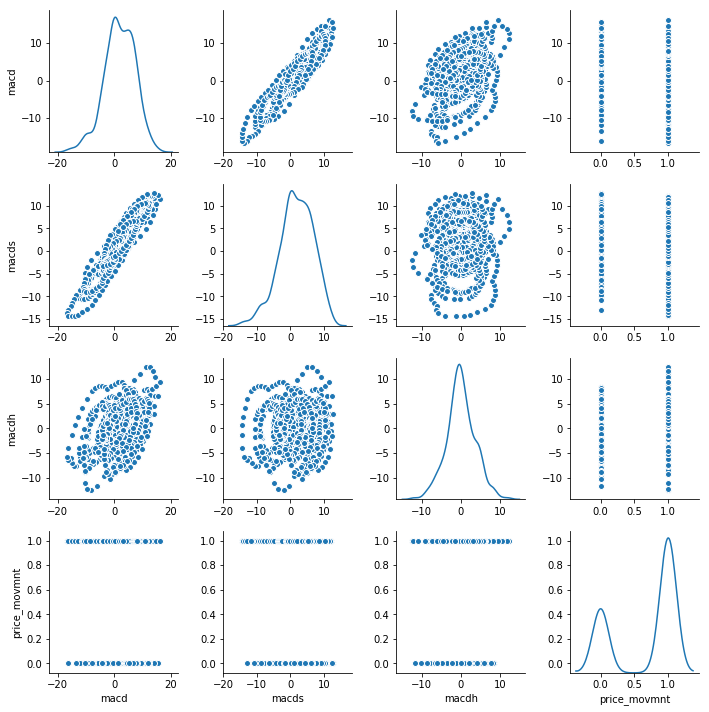

In [148]:
sns.pairplot(temp7, diag_kind='kde')

### Outliers treatment for Stock-1

In [149]:
temp_stock1.head()

,open,high,low,close,adj close,volume,vwap,nse,spy,dj,...,ts_close_pr,tr,atr,wr_10,kdjk,kdjd,kdjj,macd,macds,macdh
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,216.300003,219.167007,214.067001,218.067001,168.424866,1446501.0,650.33,8395.450195,2058.199951,17832.990234,...,209.210160,NaN,NaN,21.568720,59.477093,53.159031,72.113218,0.000000,0.000000,0.000000
2015-01-02,216.966995,218.632996,214.149994,214.800003,165.901581,3071145.0,648.43,8395.450195,2058.199951,17832.990234,...,210.488420,4.483002,4.483002,85.627429,44.442253,50.253438,32.819882,-0.073298,-0.040721,-0.065154
2015-01-03,216.966995,218.632996,214.149994,214.800003,165.901581,3071145.0,648.43,8395.450195,2058.199951,17832.990234,...,211.502996,4.483002,4.483002,85.627429,34.419026,44.975301,13.306475,-0.093396,-0.062309,-0.062174
2015-01-04,216.966995,218.632996,214.149994,214.800003,165.901581,3071145.0,648.43,8395.450195,2058.199951,17832.990234,...,212.509926,4.483002,4.483002,85.627429,27.736874,39.229159,4.752305,-0.100248,-0.075161,-0.050174
2015-01-05,215.000000,216.483002,213.766998,215.216995,166.223648,3283116.0,645.09,8378.400391,2020.579956,17501.650391,...,213.647609,2.716004,3.991004,73.148248,27.441833,35.300050,11.725400,-0.085268,-0.078168,-0.014201


In [150]:
temp_stock1.columns

Index(['open', 'high', 'low', 'close', 'adj close', 'volume', 'vwap', 'nse',
       'spy', 'dj', 'nasdaq', 'pcod', 'hld', 'rsi', 'bbul', 'bbll', 'stma',
       'ltma', 'ema', 'scul', 'scll', 'stma_cut_ltma_b', 'stma_cut_ltma_a',
       'close_pr_cut_stma_b', 'close_pr_cut_stma_a', 'close_pr_cut_ltma_b',
       'close_pr_cut_ltma_a', 'dr_stock', 'dr_nse', 'dr_spy', 'dr_dj',
       'dr_nasdaq', 'price_movmnt', 'beta', 'ts_close_pr', 'tr', 'atr',
       'wr_10', 'kdjk', 'kdjd', 'kdjj', 'macd', 'macds', 'macdh'],
      dtype='object')

In [151]:
temp_stock1[['pcod', 'hld', 'rsi', 'bbul', 'bbll', 'stma', 'ltma', 'ema', 'scul', 'scll']].head(50)

,pcod,hld,rsi,bbul,bbll,stma,ltma,ema,scul,scll
date,,,,,,,,,,
2015-01-01,NaN,5.100006,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2015-01-02,-1.100006,4.483002,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2015-01-03,2.166992,4.483002,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2015-01-04,2.166992,4.483002,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2015-01-05,0.199997,2.716004,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2015-01-06,2.250000,8.432999,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2015-01-07,-0.717010,4.117004,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2015-01-08,1.349991,10.967010,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2015-01-09,2.132996,5.165986,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [152]:
temp_stock1[['stma_cut_ltma_b', 'stma_cut_ltma_a', 'close_pr_cut_stma_b', 'close_pr_cut_stma_a',
             'close_pr_cut_ltma_b', 'close_pr_cut_ltma_a']].head(50)

,stma_cut_ltma_b,stma_cut_ltma_a,close_pr_cut_stma_b,close_pr_cut_stma_a,close_pr_cut_ltma_b,close_pr_cut_ltma_a
date,,,,,,
2015-01-01,0,0,0,0,0,0
2015-01-02,0,0,0,0,0,0
2015-01-03,0,0,0,0,0,0
2015-01-04,0,0,0,0,0,0
2015-01-05,0,0,0,0,0,0
2015-01-06,0,0,0,0,0,0
2015-01-07,0,0,0,0,0,0
2015-01-08,0,0,0,0,0,0
2015-01-09,0,0,0,0,0,0


In [153]:
temp_stock1[['dr_stock', 'dr_nse', 'dr_spy', 'dr_dj', 'dr_nasdaq', 'price_movmnt', 'beta', 'ts_close_pr']].head(50)

,dr_stock,dr_nse,dr_spy,dr_dj,dr_nasdaq,price_movmnt,beta,ts_close_pr
date,,,,,,,,
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,209.210160
2015-01-02,-0.014982,0.000000,0.000000,0.000000,0.000000,0.0,NaN,210.488420
2015-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,NaN,211.502996
2015-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,NaN,212.509926
2015-01-05,0.001941,-0.002031,-0.018278,-0.018580,-0.015706,1.0,-0.9559,213.647609
2015-01-06,-0.010069,-0.029964,-0.008893,-0.007428,-0.012859,0.0,0.3360,214.910971
2015-01-07,0.009073,-0.003107,0.011630,0.012254,0.012570,1.0,-2.9204,215.628363
2015-01-08,0.050627,0.016354,0.017888,0.018388,0.018432,1.0,3.0958,217.434996
2015-01-09,0.002581,0.006060,-0.008404,-0.009521,-0.006782,1.0,0.4259,218.622318


In [154]:
temp_stock1[['tr', 'atr', 'wr_10', 'kdjk', 'kdjd', 'kdjj', 'macd', 'macds', 'macdh']].head(50)

,tr,atr,wr_10,kdjk,kdjd,kdjj,macd,macds,macdh
date,,,,,,,,,
2015-01-01,NaN,NaN,21.568720,59.477093,53.159031,72.113218,0.000000,0.000000,0.000000
2015-01-02,4.483002,4.483002,85.627429,44.442253,50.253438,32.819882,-0.073298,-0.040721,-0.065154
2015-01-03,4.483002,4.483002,85.627429,34.419026,44.975301,13.306475,-0.093396,-0.062309,-0.062174
2015-01-04,4.483002,4.483002,85.627429,27.736874,39.229159,4.752305,-0.100248,-0.075161,-0.050174
2015-01-05,2.716004,3.991004,73.148248,27.441833,35.300050,11.725400,-0.085268,-0.078168,-0.014201
2015-01-06,8.432999,5.015700,66.728475,29.385064,33.328388,21.498415,-0.167322,-0.102334,-0.129977
2015-01-07,4.117004,4.836866,45.641996,37.709377,34.788718,43.550696,-0.129494,-0.109207,-0.040574
2015-01-08,12.317001,6.156963,8.283230,55.711841,41.763092,83.609340,0.415594,0.016912,0.797363
2015-01-09,5.165986,5.998701,14.912311,65.503791,49.676658,97.158055,0.815658,0.201427,1.228463


In [155]:
temp_stock1.columns

Index(['open', 'high', 'low', 'close', 'adj close', 'volume', 'vwap', 'nse',
       'spy', 'dj', 'nasdaq', 'pcod', 'hld', 'rsi', 'bbul', 'bbll', 'stma',
       'ltma', 'ema', 'scul', 'scll', 'stma_cut_ltma_b', 'stma_cut_ltma_a',
       'close_pr_cut_stma_b', 'close_pr_cut_stma_a', 'close_pr_cut_ltma_b',
       'close_pr_cut_ltma_a', 'dr_stock', 'dr_nse', 'dr_spy', 'dr_dj',
       'dr_nasdaq', 'price_movmnt', 'beta', 'ts_close_pr', 'tr', 'atr',
       'wr_10', 'kdjk', 'kdjd', 'kdjj', 'macd', 'macds', 'macdh'],
      dtype='object')

In [156]:
vars_outlier_trtmnt = ['volume', 'pcod', 'hld', 'rsi', 'dr_stock', 'dr_nse', 'dr_spy', 'dr_dj',
                       'dr_nasdaq', 'beta', 'tr', 'atr','macd', 'macds', 'macdh']

# Variables which can possibly take negative values
# 'pcod', 'dr_stock', 'dr_nse', 'dr_spy', 'dr_dj', 'dr_nasdaq', 'beta','macd', 'macds', 'macdh'


In [157]:
# Removing first 19 rows of the dataframe
temp_stock1 = temp_stock1.iloc[20:]

In [158]:
temp_stock1.head()

,open,high,low,close,adj close,volume,vwap,nse,spy,dj,...,ts_close_pr,tr,atr,wr_10,kdjk,kdjd,kdjj,macd,macds,macdh
date,,,,,,,,,,,,,,,,,,,,,
2015-01-21,216.000000,219.117004,214.533005,218.050003,168.411743,2767269.0,649.23,8729.500000,2032.119995,17554.279297,...,229.562413,4.583999,5.812412,76.291906,21.060722,28.545061,6.092045,-0.414401,0.135828,-1.100459
2015-01-22,218.332993,220.000000,214.983002,219.016998,169.158600,2468169.0,654.56,8761.400391,2063.149902,17813.980469,...,231.147069,5.016998,5.740410,70.285723,28.427575,28.505899,28.270928,-0.376511,0.032599,-0.818220
2015-01-23,221.132996,227.449997,219.182999,224.917007,173.715485,4353039.0,671.44,8835.599609,2051.820068,17672.599609,...,232.078035,8.432999,5.979581,19.164644,45.896836,34.302878,69.084751,0.058173,0.037744,0.040858
2015-01-24,221.132996,227.449997,219.182999,224.917007,173.715485,4353039.0,671.44,8835.599609,2051.820068,17672.599609,...,232.706089,8.266998,6.179288,19.164644,57.543009,42.049588,88.529851,0.395095,0.109553,0.571084
2015-01-25,221.132996,227.449997,219.182999,224.917007,173.715485,4353039.0,671.44,8835.599609,2051.820068,17672.599609,...,233.317614,8.266998,6.358710,19.164644,65.307125,49.802100,96.317174,0.652453,0.218545,0.867816


In [159]:
temp_stock1.columns

Index(['open', 'high', 'low', 'close', 'adj close', 'volume', 'vwap', 'nse',
       'spy', 'dj', 'nasdaq', 'pcod', 'hld', 'rsi', 'bbul', 'bbll', 'stma',
       'ltma', 'ema', 'scul', 'scll', 'stma_cut_ltma_b', 'stma_cut_ltma_a',
       'close_pr_cut_stma_b', 'close_pr_cut_stma_a', 'close_pr_cut_ltma_b',
       'close_pr_cut_ltma_a', 'dr_stock', 'dr_nse', 'dr_spy', 'dr_dj',
       'dr_nasdaq', 'price_movmnt', 'beta', 'ts_close_pr', 'tr', 'atr',
       'wr_10', 'kdjk', 'kdjd', 'kdjj', 'macd', 'macds', 'macdh'],
      dtype='object')

In [160]:
# Outliers treatment 

def outliers_treatment(name, df):
    print('\nIndependent variable =', name)
    print('Possible LOWER and UPPER boudaries for "{}" variable (below or above which are floored and ceiled to the boundaries)'.format(name))
    
    temp_set = set(df[name])
    # Using the feature 'nan != nan' to remove 'nan' from the set
    temp_set = {x for x in temp_set if x==x}        
    minimum = min(temp_set)
    maximum = max(temp_set)
    print('minimum value other than "nan" = ', minimum)
    print('maximum value other than "nan" = ', maximum)
    
    # 'nan' will be replaced by next 'minimum' value(other than 'nan')
    df[name].fillna(minimum, inplace=True)
    
    q95, q75, q25, q5 = np.percentile(df[name], [95, 75, 25, 5])
    print('q95, q75, q25, q5 values:', q95, q75, q25, q5)
    iqr = q75 - q25
    stat_min_val = q25 - 1.5 * iqr
    stat_max_val = q75 + 1.5 * iqr   
  
    # Capping and Flooring
     
    if (stat_min_val < q5): # capping to 5th percentile value
        stat_min_val = q5 
        
    if (stat_max_val > q95): # flooring to 95th percentile value 
        stat_max_val = q95          
    
    # To handle negative values in the variables
    if (name == 'pcod' or name == 'dr_stock' or name == 'dr_nse' or name == 'dr_spy' or name == 'dr_dj' 
        or name == 'dr_nasdaq' or name == 'beta' or name == 'macd' or name == 'macds' or name == 'macdh'):    
        if (stat_min_val < 0):           
            pass            
    else: # for other variables which cannot take negative values
        if (stat_min_val < 0):
            if (q5 > 0):
                stat_min_val = q5
            else:
                stat_min_val = 0
            
    print('stat_min_val =', stat_min_val)
    print('stat_max_val =', stat_max_val, '\n')       
    
    new_col = pd.DataFrame()
    new_col = df[[name]]
    new_col[new_col[name] > stat_max_val] = stat_max_val
    new_col[new_col[name] < stat_min_val] = stat_min_val
    df[name] = new_col[name]
       
    return df 

name = ''   
for idx, name in enumerate(vars_outlier_trtmnt):
    new_df = pd.DataFrame()
    new_df = outliers_treatment(name, temp_stock1)    
    temp_stock1 = new_df



Independent variable = volume
Possible LOWER and UPPER boudaries for "volume" variable (below or above which are floored and ceiled to the boundaries)
minimum value other than "nan" =  206300.0
maximum value other than "nan" =  38419449.0
q95, q75, q25, q5 values: 7673183.399999999 4789755.0 2570790.0 1652283.4000000001
stat_min_val = 1652283.4000000001
stat_max_val = 7673183.399999999 


Independent variable = pcod
Possible LOWER and UPPER boudaries for "pcod" variable (below or above which are floored and ceiled to the boundaries)
minimum value other than "nan" =  -26.50002999999998
maximum value other than "nan" =  19.799987999999985
q95, q75, q25, q5 values: 7.1000360000000455 2.200012000000015 -0.9670099999999593 -5.49040480000001
stat_min_val = -5.49040480000001
stat_max_val = 6.950544999999977 


Independent variable = hld
Possible LOWER and UPPER boudaries for "hld" variable (below or above which are floored and ceiled to the boundaries)
minimum value other than "nan" =  2.367

# Model building for Stock-1

In [161]:
temp_stock1.isnull().sum()

open                    0
high                    0
low                     0
close                   0
adj close               0
volume                  0
vwap                    0
nse                     0
spy                     0
dj                      0
nasdaq                  0
pcod                    0
hld                     0
rsi                     0
bbul                    0
bbll                    0
stma                    0
ltma                   99
ema                     0
scul                    0
scll                    0
stma_cut_ltma_b         0
stma_cut_ltma_a         0
close_pr_cut_stma_b     0
close_pr_cut_stma_a     0
close_pr_cut_ltma_b     0
close_pr_cut_ltma_a     0
dr_stock                0
dr_nse                  0
dr_spy                  0
dr_dj                   0
dr_nasdaq               0
price_movmnt            0
beta                    0
ts_close_pr             0
tr                      0
atr                     0
wr_10                   0
kdjk        

In [162]:
temp_stock1.head(50)

,open,high,low,close,adj close,volume,vwap,nse,spy,dj,...,ts_close_pr,tr,atr,wr_10,kdjk,kdjd,kdjj,macd,macds,macdh
date,,,,,,,,,,,,,,,,,,,,,
2015-01-21,216.000000,219.117004,214.533005,218.050003,168.411743,2767269.0,649.23,8729.500000,2032.119995,17554.279297,...,229.562413,4.889996,6.782143,76.291906,21.060722,28.545061,6.092045,-0.414401,0.135828,-1.100459
2015-01-22,218.332993,220.000000,214.983002,219.016998,169.158600,2468169.0,654.56,8761.400391,2063.149902,17813.980469,...,231.147069,5.016998,6.782143,70.285723,28.427575,28.505899,28.270928,-0.376511,0.032599,-0.818220
2015-01-23,221.132996,227.449997,219.182999,224.917007,173.715485,4353039.0,671.44,8835.599609,2051.820068,17672.599609,...,232.078035,8.432999,6.782143,19.164644,45.896836,34.302878,69.084751,0.058173,0.037744,0.040858
2015-01-24,221.132996,227.449997,219.182999,224.917007,173.715485,4353039.0,671.44,8835.599609,2051.820068,17672.599609,...,232.706089,8.266998,6.782143,19.164644,57.543009,42.049588,88.529851,0.395095,0.109553,0.571084
2015-01-25,221.132996,227.449997,219.182999,224.917007,173.715485,4353039.0,671.44,8835.599609,2051.820068,17672.599609,...,233.317614,8.266998,6.782143,19.164644,65.307125,49.802100,96.317174,0.652453,0.218545,0.867816
2015-01-26,221.132996,227.449997,219.182999,224.917007,173.715485,4353039.0,671.44,8835.599609,2057.090088,17678.699219,...,234.066883,8.266998,6.782143,19.164644,70.483202,56.695801,98.058004,0.845146,0.344245,1.001803
2015-01-27,226.300003,231.617004,220.266998,230.682999,178.168900,5802642.0,679.58,8910.500000,2029.550049,17387.210938,...,234.949160,11.350006,6.924134,5.372785,78.531206,63.974269,107.645080,1.394112,0.554727,1.678769
2015-01-28,229.617004,236.533005,228.332993,235.417007,181.825211,5719488.0,703.21,8914.299805,2002.160034,17191.369141,...,235.231759,8.200012,7.029517,5.004475,84.005434,70.651324,110.713653,2.144411,0.873280,2.542262
2015-01-29,237.082993,245.917007,235.850006,244.617004,188.930862,7673183.4,723.69,8952.349609,2021.250000,17416.849609,...,236.698693,10.500000,7.313001,4.126994,87.956207,76.419618,111.029383,3.368078,1.373013,3.990129


In [163]:
temp_stock1.columns

Index(['open', 'high', 'low', 'close', 'adj close', 'volume', 'vwap', 'nse',
       'spy', 'dj', 'nasdaq', 'pcod', 'hld', 'rsi', 'bbul', 'bbll', 'stma',
       'ltma', 'ema', 'scul', 'scll', 'stma_cut_ltma_b', 'stma_cut_ltma_a',
       'close_pr_cut_stma_b', 'close_pr_cut_stma_a', 'close_pr_cut_ltma_b',
       'close_pr_cut_ltma_a', 'dr_stock', 'dr_nse', 'dr_spy', 'dr_dj',
       'dr_nasdaq', 'price_movmnt', 'beta', 'ts_close_pr', 'tr', 'atr',
       'wr_10', 'kdjk', 'kdjd', 'kdjj', 'macd', 'macds', 'macdh'],
      dtype='object')

In [164]:
temp_stock1[['open', 'high', 'low', 'close', 'adj close', 'volume', 'vwap', 'nse']].corr()

,open,high,low,close,adj close,volume,vwap,nse
open,1.000000,0.998802,0.998906,0.997612,0.993662,-0.148839,-0.721875,0.780555
high,0.998802,1.000000,0.998759,0.999140,0.994760,-0.130856,-0.722107,0.781884
low,0.998906,0.998759,1.000000,0.999004,0.994804,-0.155909,-0.719503,0.781011
close,0.997612,0.999140,0.999004,1.000000,0.995617,-0.138573,-0.721255,0.782217
adj close,0.993662,0.994760,0.994804,0.995617,1.000000,-0.139235,-0.724956,0.769999
volume,-0.148839,-0.130856,-0.155909,-0.138573,-0.139235,1.000000,0.061752,-0.061375
vwap,-0.721875,-0.722107,-0.719503,-0.721255,-0.724956,0.061752,1.000000,-0.738193
nse,0.780555,0.781884,0.781011,0.782217,0.769999,-0.061375,-0.738193,1.000000


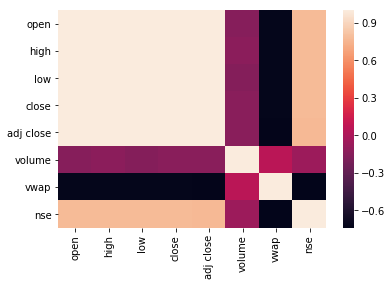

In [165]:
sns.heatmap(temp_stock1[['open', 'high', 'low', 'close', 'adj close', 'volume', 'vwap', 'nse']].corr())

In [166]:
temp_stock1.drop(['open', 'high', 'low', 'close', 'nse'], axis=1, inplace=True)

In [167]:
temp_stock1[['spy', 'dj', 'nasdaq', 'pcod', 'hld', 'rsi', 'bbul', 'bbll', 'stma']].corr()

,spy,dj,nasdaq,pcod,hld,rsi,bbul,bbll,stma
spy,1.000000,0.995111,0.988711,0.048227,0.407226,0.033338,0.887990,0.876806,0.885857
dj,0.995111,1.000000,0.983191,0.042341,0.407214,0.024281,0.874053,0.863010,0.871937
nasdaq,0.988711,0.983191,1.000000,0.053082,0.412091,0.010366,0.892077,0.883187,0.891055
pcod,0.048227,0.042341,0.053082,1.000000,-0.008667,-0.061539,0.051242,0.045776,0.048816
hld,0.407226,0.407214,0.412091,-0.008667,1.000000,-0.038056,0.486803,0.457121,0.474385
rsi,0.033338,0.024281,0.010366,-0.061539,-0.038056,1.000000,-0.012046,-0.037772,-0.024377
bbul,0.887990,0.874053,0.892077,0.051242,0.486803,-0.012046,1.000000,0.985592,0.996732
bbll,0.876806,0.863010,0.883187,0.045776,0.457121,-0.037772,0.985592,1.000000,0.996035
stma,0.885857,0.871937,0.891055,0.048816,0.474385,-0.024377,0.996732,0.996035,1.000000


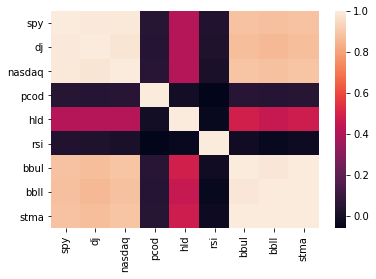

In [168]:
sns.heatmap(temp_stock1[['spy', 'dj', 'nasdaq', 'pcod', 'hld', 'rsi', 'bbul', 'bbll', 'stma']].corr())

In [169]:
temp_stock1.drop(['dj', 'nasdaq', 'bbul', 'bbll', 'stma'], axis=1, inplace=True)

In [170]:
temp_stock1[['ltma', 'ema', 'scul', 'scll', 'stma_cut_ltma_b', 'stma_cut_ltma_a']].corr()

,ltma,ema,scul,scll,stma_cut_ltma_b,stma_cut_ltma_a
ltma,1.000000,0.979937,-0.023947,0.043381,0.021676,0.020247
ema,0.979937,1.000000,-0.025957,0.053250,0.021346,0.016435
scul,-0.023947,-0.025957,1.000000,-0.053789,0.012497,-0.026179
scll,0.043381,0.053250,-0.053789,1.000000,-0.017315,0.038686
stma_cut_ltma_b,0.021676,0.021346,0.012497,-0.017315,1.000000,-0.008427
stma_cut_ltma_a,0.020247,0.016435,-0.026179,0.038686,-0.008427,1.000000


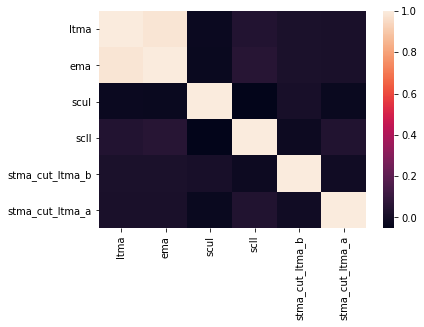

In [171]:
sns.heatmap(temp_stock1[['ltma', 'ema', 'scul', 'scll', 'stma_cut_ltma_b', 'stma_cut_ltma_a']].corr())

In [172]:
temp_stock1.drop(['ema'], axis=1, inplace=True)

In [173]:
temp_stock1[['close_pr_cut_stma_b', 'close_pr_cut_stma_a', 'close_pr_cut_ltma_b', 'close_pr_cut_ltma_a']].corr()

,close_pr_cut_stma_b,close_pr_cut_stma_a,close_pr_cut_ltma_b,close_pr_cut_ltma_a
close_pr_cut_stma_b,1.000000,-0.054848,0.269406,-0.036103
close_pr_cut_stma_a,-0.054848,1.000000,-0.036103,0.213859
close_pr_cut_ltma_b,0.269406,-0.036103,1.000000,-0.023764
close_pr_cut_ltma_a,-0.036103,0.213859,-0.023764,1.000000


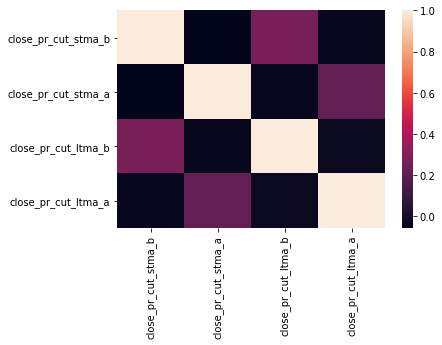

In [174]:
sns.heatmap(temp_stock1[['close_pr_cut_stma_b', 'close_pr_cut_stma_a', 'close_pr_cut_ltma_b', 'close_pr_cut_ltma_a']].corr())

In [175]:
temp_stock1[['dr_stock', 'dr_nse', 'dr_spy', 'dr_dj', 'dr_nasdaq', 'beta', 'ts_close_pr']].corr()

,dr_stock,dr_nse,dr_spy,dr_dj,dr_nasdaq,beta,ts_close_pr
dr_stock,1.000000,0.389079,0.069138,0.068075,0.085404,0.066979,-0.027680
dr_nse,0.389079,1.000000,0.259830,0.252780,0.249727,0.059996,0.028434
dr_spy,0.069138,0.259830,1.000000,0.942658,0.904011,0.051514,0.029675
dr_dj,0.068075,0.252780,0.942658,1.000000,0.797696,0.054972,0.042172
dr_nasdaq,0.085404,0.249727,0.904011,0.797696,1.000000,0.086443,0.015340
beta,0.066979,0.059996,0.051514,0.054972,0.086443,1.000000,0.006794
ts_close_pr,-0.027680,0.028434,0.029675,0.042172,0.015340,0.006794,1.000000


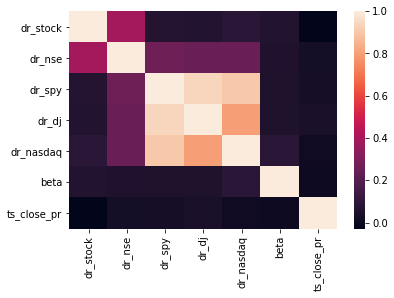

In [176]:
sns.heatmap(temp_stock1[['dr_stock', 'dr_nse', 'dr_spy', 'dr_dj', 'dr_nasdaq', 'beta', 'ts_close_pr']].corr())

In [177]:
temp_stock1.drop(['dr_stock', 'dr_dj', 'dr_nasdaq', 'beta', 'ts_close_pr'], axis=1, inplace=True)

In [178]:
temp_stock1[['tr', 'atr', 'wr_10', 'kdjk', 'kdjd', 'kdjj', 'macd', 'macds', 'macdh']].corr()

,tr,atr,wr_10,kdjk,kdjd,kdjj,macd,macds,macdh
tr,1.000000,0.616341,0.037711,-0.027692,-0.029164,-0.020619,0.060966,0.088041,-0.063952
atr,0.616341,1.000000,0.051930,-0.045286,-0.045259,-0.036422,-0.029033,0.012816,-0.102320
wr_10,0.037711,0.051930,1.000000,-0.892094,-0.680457,-0.951928,-0.331254,-0.098040,-0.754273
kdjk,-0.027692,-0.045286,-0.892094,1.000000,0.916687,0.896129,0.488467,0.227890,0.861677
kdjd,-0.029164,-0.045259,-0.680457,0.916687,1.000000,0.644126,0.625140,0.388322,0.816998
kdjj,-0.020619,-0.036422,-0.951928,0.896129,0.644126,1.000000,0.240747,0.004960,0.742065
macd,0.060966,-0.029033,-0.331254,0.488467,0.625140,0.240747,1.000000,0.941217,0.354967
macds,0.088041,0.012816,-0.098040,0.227890,0.388322,0.004960,0.941217,1.000000,0.040804
macdh,-0.063952,-0.102320,-0.754273,0.861677,0.816998,0.742065,0.354967,0.040804,1.000000


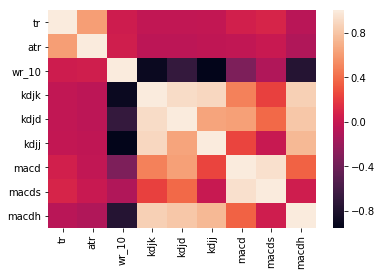

In [179]:
sns.heatmap(temp_stock1[['tr', 'atr', 'wr_10', 'kdjk', 'kdjd', 'kdjj', 'macd', 'macds', 'macdh']].corr())

In [180]:
temp_stock1.drop(['atr', 'kdjk', 'kdjd', 'kdjj', 'macd'], axis=1, inplace=True)

In [181]:
temp_stock1.columns

Index(['adj close', 'volume', 'vwap', 'spy', 'pcod', 'hld', 'rsi', 'ltma',
       'scul', 'scll', 'stma_cut_ltma_b', 'stma_cut_ltma_a',
       'close_pr_cut_stma_b', 'close_pr_cut_stma_a', 'close_pr_cut_ltma_b',
       'close_pr_cut_ltma_a', 'dr_nse', 'dr_spy', 'price_movmnt', 'tr',
       'wr_10', 'macds', 'macdh'],
      dtype='object')

In [182]:
temp_stock1[['adj close', 'volume', 'vwap', 'spy', 'pcod', 'hld', 'rsi', 'ltma', 'scul', 'scll', 
             'stma_cut_ltma_b', 'stma_cut_ltma_a', 'close_pr_cut_stma_b', 'close_pr_cut_stma_a', 
             'close_pr_cut_ltma_b', 'close_pr_cut_ltma_a', 'dr_nse', 'dr_spy', 'price_movmnt',
             'tr', 'wr_10', 'macds', 'macdh']].corr()

,adj close,volume,vwap,spy,pcod,hld,rsi,ltma,scul,scll,...,close_pr_cut_stma_a,close_pr_cut_ltma_b,close_pr_cut_ltma_a,dr_nse,dr_spy,price_movmnt,tr,wr_10,macds,macdh
adj close,1.000000,-0.139235,-0.724956,0.881512,0.036121,0.465622,0.072954,0.972701,0.021568,0.012385,...,-0.006443,-0.008549,-0.020569,0.037463,0.032505,-0.003410,0.460765,-0.067268,0.152678,0.028157
volume,-0.139235,1.000000,0.061752,-0.126238,-0.072484,0.376368,-0.061068,-0.124003,0.262094,0.120147,...,0.003907,0.049032,0.057416,-0.032672,-0.003736,0.069372,0.387655,-0.076390,-0.129081,-0.004512
vwap,-0.724956,0.061752,1.000000,-0.757661,-0.010081,-0.399256,0.081217,-0.818674,0.032310,-0.046437,...,-0.000067,-0.014297,-0.013104,-0.009698,-0.027020,0.015319,-0.393695,-0.047294,0.047954,0.050130
spy,0.881512,-0.126238,-0.757661,1.000000,0.048227,0.407226,0.033338,0.915304,-0.023147,0.011268,...,0.000350,0.002044,-0.007484,0.051868,0.057907,-0.016672,0.399629,-0.050985,0.070571,0.019116
pcod,0.036121,-0.072484,-0.010081,0.048227,1.000000,-0.008667,-0.061539,0.044492,-0.056068,-0.009713,...,-0.113387,0.094760,-0.100086,0.174717,0.037781,0.139111,-0.005248,0.188773,0.003644,-0.136999
hld,0.465622,0.376368,-0.399256,0.407226,-0.008667,1.000000,-0.038056,0.459201,0.195309,0.212585,...,0.112425,0.070460,0.088171,-0.106511,0.023136,-0.071676,0.989148,0.050113,0.094371,-0.066497
rsi,0.072954,-0.061068,0.081217,0.033338,-0.061539,-0.038056,1.000000,-0.021077,0.291230,-0.253321,...,-0.073485,-0.028309,-0.130123,0.075151,0.015026,0.155908,-0.037872,-0.519507,0.669143,0.588716
ltma,0.972701,-0.124003,-0.818674,0.915304,0.044492,0.459201,-0.021077,1.000000,-0.023947,0.043381,...,-0.001483,-0.009693,-0.009526,0.020332,0.040389,-0.035168,0.452511,0.009690,0.027405,-0.019060
scul,0.021568,0.262094,0.032310,-0.023147,-0.056068,0.195309,0.291230,-0.023947,1.000000,-0.053789,...,-0.066787,0.049563,-0.020581,0.114962,0.042482,0.173578,0.208982,-0.368352,0.079443,0.295355
scll,0.012385,0.120147,-0.046437,0.011268,-0.009713,0.212585,-0.253321,0.043381,-0.053789,1.000000,...,0.024709,-0.029077,0.174052,-0.126722,-0.000378,-0.208659,0.214596,0.290829,-0.076982,-0.260620


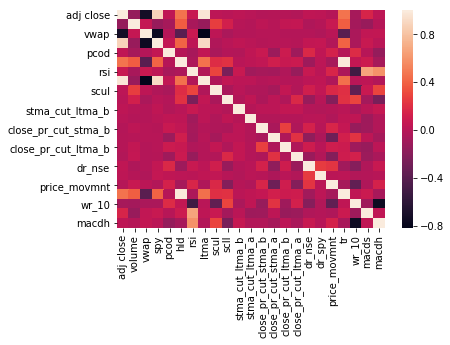

In [183]:
sns.heatmap(temp_stock1[['adj close', 'volume', 'vwap', 'spy', 'pcod', 'hld', 'rsi', 'ltma', 'scul', 'scll', 
             'stma_cut_ltma_b', 'stma_cut_ltma_a', 'close_pr_cut_stma_b', 'close_pr_cut_stma_a', 
             'close_pr_cut_ltma_b', 'close_pr_cut_ltma_a', 'dr_nse', 'dr_spy', 'price_movmnt',
             'tr', 'wr_10', 'macds', 'macdh']].corr())

In [184]:
temp_stock1.drop(['adj close', 'hld', 'ltma'], axis=1, inplace=True)

In [185]:
temp_stock1.columns

Index(['volume', 'vwap', 'spy', 'pcod', 'rsi', 'scul', 'scll',
       'stma_cut_ltma_b', 'stma_cut_ltma_a', 'close_pr_cut_stma_b',
       'close_pr_cut_stma_a', 'close_pr_cut_ltma_b', 'close_pr_cut_ltma_a',
       'dr_nse', 'dr_spy', 'price_movmnt', 'tr', 'wr_10', 'macds', 'macdh'],
      dtype='object')

In [186]:
y = temp_stock1.price_movmnt.values
X = temp_stock1.drop ('price_movmnt' , axis =1 ).values

In [187]:
# Standardise the data

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Splitting the data into train and test sets
X_train, X_test, y_train , y_test = train_test_split (X, y , test_size = 0.3 , random_state = 42)

In [188]:
# Import suite of algorithms

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neural_network import MLPClassifier

In [189]:
# Create objects of required models

models = []
models.append(("LR",LogisticRegression()))
models.append(("GNB",GaussianNB()))
models.append(("KNN",KNeighborsClassifier()))
models.append(("DecisionTree",DecisionTreeClassifier()))
models.append(("LDA",  LinearDiscriminantAnalysis()))
models.append(("QDA",  QuadraticDiscriminantAnalysis()))
models.append(("AdaBoost", AdaBoostClassifier()))
models.append(("SVM Linear",SVC(kernel="linear")))
models.append(("SVM RBF",SVC(kernel="rbf")))
models.append(("Random Forest",  RandomForestClassifier()))
models.append(("Bagging",BaggingClassifier()))
models.append(("Calibrated classifier",CalibratedClassifierCV()))
models.append(("GradientBoosting",GradientBoostingClassifier()))
models.append(("LinearSVC",LinearSVC()))
models.append(("Ridge",RidgeClassifier()))
models.append(("MLP",MLPClassifier()))

In [190]:
# Find accuracy of models

results = []
for name,model in models:
    kfold = KFold(n_splits=10, random_state=0)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    results.append(tuple([name,cv_result.mean(), cv_result.std()]))
  
results.sort(key=lambda x: x[1], reverse = True)    
for i in range(len(results)):
    print('{:20s} {:2.2f} (+/-) {:2.2f} '.format(results[i][0] , results[i][1] * 100, results[i][2] * 100))

AdaBoost             85.13 (+/-) 2.61 
GradientBoosting     84.47 (+/-) 3.22 
MLP                  84.19 (+/-) 3.03 
SVM RBF              81.55 (+/-) 2.79 
Bagging              80.75 (+/-) 3.69 
Random Forest        80.08 (+/-) 3.34 
KNN                  79.55 (+/-) 2.68 
Calibrated classifier 79.16 (+/-) 3.57 
LDA                  79.03 (+/-) 3.85 
LinearSVC            78.77 (+/-) 4.36 
Ridge                78.77 (+/-) 3.98 
LR                   78.64 (+/-) 4.76 
SVM Linear           78.50 (+/-) 3.14 
DecisionTree         76.63 (+/-) 2.68 
QDA                  62.52 (+/-) 8.90 
GNB                  44.35 (+/-) 1.85 
